In [10]:
from langgraph.graph import StateGraph, END, START
from typing import Dict, Any
from langgraph.graph import StateGraph, END, START
from typing import Dict, Any, List, TypedDict
from agents.EventExtractionAgent import execute_event_extractor

# Agents

## Event Extraction Agent

In [11]:
# ---First Agent is the Event Extraction Agent---

from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM
from typing import Dict, List, Any, TypedDict, Literal, Optional, Union, Tuple
import re

# Make sure the function is available for import
__all__ = ['execute_event_extractor']

def execute_event_extractor(state: Dict[str, Any]) -> Dict[str, Any]:
    """
    Modified EventExtractorAgent to work with LangGraph 0.4.8.
    Expects input state to contain 'story' key, adds 'events' to output state.
    """
    story = state.get("story", "")
    
    # Define the prompt template (moved inside function for compatibility)
    template = """
    You are an expert in literary analysis, designed to extract and summarize the most important events from long texts.

    Context:
    {context}


    Task:
    Identify the most important events ensuring that each includes:

    Step 1:
    Extract any information about the setting [location, atmosphere, time period]
    example: "In a dark forest with long trees during midnight

    Step 2:
    Extract any information about the characters [physical description, emotions]

    Determine if the character is a key participant in the event.

    If yes, include them in the event description.
    If no, do not include them.

    Example: 
    Pigsy -> Key participant
    Sandy -> Key participant
    Jeff -> Not a key participant
    Characters: "Pigsy (a small pink pig with a twisted tail), Sandy (a tall and beautiful young lady with long black hair)"

    Step 3:
    Extract any information about the actions [what is happening in the scene]
    It should be a clear and concise description of the event
    Do not include vague or unnecessary descriptions.
    Example: "Pigsy and Sandy are walking through the forest"
    Negative example: "Pigsy and Sandy who was sick this morning are walking through the forest"

    Step 4: 
    Create a prompt from the extracted information
    - prompt should be specific, clear, and concise
    - prompt is used to generate an image of the event, so make it discriptive but brief
    Example: "In a dark forest with long trees during midnight, a small pink pig with a twisted tail and a tall and beautiful young lady with long black hair are walking through the forest."
    Negative example: "In a dark forest with long trees during midnight, a small pink animal and a young person are walking through the forest, but they are also talking about their plans for the future."

    Step 5:
    Add character descriptions to the prompt from the context
    - character discriptions should be physical 
    Example: "In a dark forest with long trees during midnight, a small chubby pink pig with a twisted tail and black hooves and a tall and beautiful young lady with long black hair and a white dress are walking through the forest."
    
    Output Format:
    For each event, structure your response as follows:

    **Event X:**
    - **Setting:** [Describe the environment vividly]  
    - **Characters:** [List the key individuals and their emotional states]  
    - **Actions:** [Explain what happens breifly but clearly]  
    - **Prompt:** [Combine the setting, characters, and actions into a coherent narrative]

    Ensure that each event is distinct and captures the essence of the story.

    Guidelines:
    - Your output must be precise and strictly adhere to the given context. Inaccuracies, fabrications, or assumptions are not tolerated. Ensure that all extracted events are factually correct and directly supported by the text.
    - Continue extracting events until the full narrative is covered. 
    - Avoid using proper nouns when referring to characters or locations; instead, use descriptive terms that capture their essence without naming them directly.
    - If some information is missing, do not fabricate details or indicate that it is missing. Instead, focus on the information that is available and provide a clear, concise summary of the events based on the provided context.
    """
    prompt = ChatPromptTemplate.from_template(template)
    model = OllamaLLM(model="llama3.1")
    chain = prompt | model

    # Process the story
    result = chain.invoke({"context": story})
    pattern = r'\*\*Prompt:\*\* *"([^"]+)"'
    events = re.findall(pattern, result)
    
    # Update and return the state
    state["story"] = story
    state["events"] = events

    print("\nExtracted Events:\n")
    for i, event in enumerate(events, start=1):
        print(f"Event {i}:", event)
    
    return state



## Event Evaluation

In [26]:
from sentence_transformers import SentenceTransformer, util
import bert_score
from rouge_score import rouge_scorer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import numpy as np
from nltk.translate.meteor_score import meteor_score
import nltk
from typing import Dict, List, Any, TypedDict, Literal, Optional, Union, Tuple

nltk.download('wordnet')



__all__ = ['execute_event_evaluator']

def execute_event_evaluator(state: Dict[str,Any]) -> Dict[str, Any]:
        
        original_text = state.get("story", "")
        summaries = state.get("events", [])

        # Load the pre-trained model
        sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
        # --- 1. Semantic Similarity (S-BERT cosine) ---
        summary = ""
        for i in summaries:
             summary += i + "\n"
        summary = summary.strip()  # Clean up the summary text
        def compute_semantic_similarity_sbert(original_text: str, summary: str) -> float:
            embeddings = sbert_model.encode([original_text, summary], convert_to_tensor=True)
            similarity = util.pytorch_cos_sim(embeddings[0], embeddings[1]).item()
            return similarity


        # --- 2. Content Similarity (BERTScore) ---
        def compute_bertscore(original_text: str, summary: str) -> float:
            P, R, F1 = bert_score.score([summary], [original_text], lang='en', verbose=False)
            return F1[0].item()


        # --- 3. Coverage (ROUGE-L) ---
        def compute_rouge_l(original_text: str, summary: str) -> float:
            scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
            score = scorer.score(original_text, summary)
            return score['rougeL'].fmeasure


        # --- 4. Relevance ---
        def relevance(original_text, summary):
            
            reference = [original_text.split()]
            hypothesis = summary.split()
            score = meteor_score(reference, hypothesis)
            return score

        # --- 5. Relevance Spread ---

        def relevance_spread(original_text, summary):
        
            sections = [original_text[i:i + len(original_text)//4] for i in range(0, len(original_text), len(original_text)//4)]
            meteor_scores = [meteor_score([s.split()], summary.split()) for s in sections if s]
            if not meteor_scores or len(meteor_scores) < 2:
                return 0
            std_dev = np.std(meteor_scores)
            mean_score = np.mean(meteor_scores)
            return float(std_dev / mean_score) if mean_score != 0 else 0
        
        print("\nEvent Evaluation:\n")

        print("Semantic Similarity (SBERT):", compute_semantic_similarity_sbert(original_text, summary))
        print("Content Similarity (BERTScore):", compute_bertscore(original_text, summary))
        print("Coverage (ROUGE-L):", compute_rouge_l(original_text, summary))
        print("Relevance (METEOR):", relevance(original_text, summary))
        print("Relevance Spread:", relevance_spread(original_text, summary))
    
        
        return state


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zeina\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Prompt Refinement Agent

### Models Loading

In [1]:
import torch
import random
import ollama
from langchain.llms import Ollama
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from diffusers import StableDiffusionPipeline
from transformers import CLIPModel, CLIPProcessor
import pandas as pd
# from diffusers import AutoPipelineForText2Image
from transformers import PreTrainedTokenizerFast
from diffusers import DiffusionPipeline
from diffusers import StableDiffusionXLPipeline

c:\Users\zeina\Desktop\AgenticWorkflowGP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\zeina\Desktop\AgenticWorkflowGP\lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\zeina\Desktop\AgenticWorkflowGP\lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\zeina\Desktop\AgenticWorkflowGP\lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pyt

In [2]:
llm = Ollama(model="llama3.1")

pipe = StableDiffusionXLPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16").to("cuda")
total_params = sum(p.numel() * p.element_size() for p in pipe.unet.parameters())
total_params += sum(p.numel() * p.element_size() for p in pipe.text_encoder.parameters())
total_params += sum(p.numel() * p.element_size() for p in pipe.vae.parameters())
print(f"Model memory size (in RAM): {total_params / 1e9:.2f} GB")



C:\Users\zeina\AppData\Local\Temp\ipykernel_21328\365801723.py:1: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(model="llama3.1")
Couldn't connect to the Hub: 429 Client Error: Too Many Requests for url: https://huggingface.co/api/models/stabilityai/stable-diffusion-xl-base-1.0.
Will try to load from local cache.
Loading pipeline components...:  29%|██▊       | 2/7 [00:00<00:01,  4.31it/s]c:\Users\zeina\Desktop\AgenticWorkflowGP\lib\site-packages\diffusers\utils\outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
c:\Users\zeina\Desktop\A

Model memory size (in RAM): 5.55 GB


### Clip Scorer

In [3]:
# Load model and processor
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

In [4]:
import torch
from PIL import Image
import spacy  # For noun phrase extraction

# Load NLP model for extracting noun phrases
nlp = spacy.load("en_core_web_sm")

def extract_noun_phrases(text):
    """Extracts noun phrases from a given text using SpaCy."""
    doc = nlp(text)
    return [chunk.text for chunk in doc.noun_chunks]

def compute_decomposed_clip_score(image_path, text_prompt):
    """Computes CLIP Score by averaging similarity scores for each noun phrase in the prompt."""
    # Ensure `image_path` is a string
    if isinstance(image_path, list):
        image_path = image_path[0]  # Extract the actual path if it's a list

    # Load image correctly
    image = Image.open(image_path)

    # Extract meaningful chunks (noun phrases)
    noun_phrases = extract_noun_phrases(text_prompt)
    
    if not noun_phrases:
        noun_phrases = [text_prompt]  # If no noun phrases are detected, use full prompt
    
    scores = []
    
    for phrase in noun_phrases:
        # Tokenize text (ensure it's within CLIP's 77-token limit)
        inputs = processor(images=image, text=phrase, return_tensors="pt")

        # Move inputs and model to the same device
        inputs = {key: value.to("cuda") for key, value in inputs.items()}
        model.to("cuda")

        with torch.no_grad():
            outputs = model(**inputs)
            image_features = outputs.image_embeds
            text_features = outputs.text_embeds

        # Normalize features
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # Compute similarity (CLIP score)
        similarity = (image_features @ text_features.T).item()
        scores.append(similarity)

    # Compute final decomposed CLIP score (average of all phrase scores)
    final_score = sum(scores) / len(scores)
    return final_score




### DSG Scorer

In [5]:
import ollama
from pprint import pprint

def generate_dsg_with_llama(prompt):
    # === 1. Tuple Generation (Fixed) ===
    tuple_prompt = f"""
    Extract ALL elements from this prompt. Follow STRICT rules:
    
    RULES:
    1. Format: "id | type - subtype (arguments)"
    2. Types: entity, attribute, relation
    3. Subtypes:
       - entity: vehicle, object, person
       - attribute: color, state, condition
       - relation: spatial
    4. MUST include ALL mentioned elements
    5. NO additional text or explanations

    EXAMPLE INPUT: "A red apple on a wooden table"
    EXAMPLE OUTPUT:
    1 | entity - object (apple)
    2 | attribute - color (apple, red)
    3 | entity - object (table)
    4 | attribute - material (table, wooden)
    5 | relation - spatial (apple, table, on)

    CURRENT PROMPT: "{prompt}"
    OUTPUT:
    """
    tuple_response = ollama.generate(
        model="llama3.1",
        prompt=tuple_prompt,
        options={"temperature": 0.1, "max_tokens": 500}
    )
    tuples = [line.strip() for line in tuple_response["response"].strip().split("\n") 
              if "|" in line and line.strip()]
    tuples = "\n".join(tuples)

    # === 2. Yes/No Question Generation (Fixed) ===
    question_prompt = f"""
    Create YES/NO questions about this scene. Follow STRICT rules:
    
    RULES:
    1. Only ask about EXPLICITLY mentioned elements
    2. Start every question with "Is" or "Are"
    3. Format: "id | question"
    4. MUST cover all main objects/attributes/relations
    5. NO hypotheticals (e.g., riders, owners)

    BAD EXAMPLE: "Does the motorcycle have a horn?" 
    (not mentioned)
    BAD EXAMPLE: "Where is the motorcycle?"
    (not a yes/no question)
    
    GOOD EXAMPLE: "Is the motorcycle blue?"

    EXAMPLE OUTPUT FOR "A red apple on a table":
    1 | Is there an apple?
    2 | Is the apple red?
    3 | Is there a table?
    4 | Is the apple on the table?

    CURRENT PROMPT: "{prompt}"
    QUESTIONS:
    """
    question_response = ollama.generate(
        model="llama3.1",
        prompt=question_prompt,
        options={"temperature": 0.1, "max_tokens": 500}
    )
    questions = [line.strip() for line in question_response["response"].strip().split("\n") 
                if "|" in line and line.strip()]
    questions = "\n".join(questions)

    # === 3. Dependency Generation (Fixed) ===
    dependency_prompt = f"""
    Generate dependencies for these tuples. Follow STRICT rules:
    
    RULES:
    1. Attributes depend on their entity
    2. Relations depend on their subject AND object
    3. Format: "id | parent_ids" (comma separated or empty)
    4. Entities have no dependencies
    5. NO explanations

    EXAMPLE INPUT:
    1 | entity - object (apple)
    2 | attribute - color (apple, red)
    3 | relation - spatial (apple, table, on)

    EXAMPLE OUTPUT:
    1 |
    2 | 1
    3 | 1

    CURRENT TUPLES:
    {tuples}
    
    DEPENDENCIES:
    """
    dependency_response = ollama.generate(
        model="llama3.1",
        prompt=dependency_prompt,
        options={"temperature": 0.1, "max_tokens": 500}
    )
    dependencies = [line.strip() for line in dependency_response["response"].strip().split("\n") 
                  if "|" in line and line.strip()]
    dependencies = "\n".join(dependencies)

    return {
        "tuples": tuples,
        "questions": questions,
        "dependencies": dependencies
    }


In [6]:
from PIL import Image
from transformers import BlipProcessor, BlipForQuestionAnswering

def evaluate_dsg_independent(dsg_output, generated_image):
    """Evaluate DSG questions without dependency checks using BLIP VQA"""
    
    # Initialize BLIP model
    processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
    model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
    
    # 1) Parse questions
    qid2question = {}
    for line in dsg_output['questions'].split('\n'):
        if '|' in line:
            qid, question = line.split('|', 1)
            qid2question[int(qid.strip())] = question.strip()
    
    # 2) Process image (handles both paths and PIL Images)
    if isinstance(generated_image, str):
        raw_image = Image.open(generated_image).convert('RGB')
    else:
        raw_image = generated_image.convert('RGB') if hasattr(generated_image, 'convert') else generated_image
    
    # 3) Get answers and scores
    qid2answer = {}
    qid2scores = {}
    
    for qid, question in qid2question.items():
        # BLIP-specific processing
        inputs = processor(raw_image, question, return_tensors="pt")
        out = model.generate(**inputs)
        answer = processor.decode(out[0], skip_special_tokens=True)
        
        qid2answer[qid] = answer
        # Handle BLIP's verbose answers (check for "yes", "yeah", etc.)
        qid2scores[qid] = 1 if any(yes_word in answer.lower() for yes_word in ['yes', 'yeah', 'true']) else 0
    
    # 4) Calculate average score
    average_score = sum(qid2scores.values()) / len(qid2scores)
    
    # 5) Print results
    print("Independent Question Evaluation (BLIP):")
    for qid in sorted(qid2question.keys()):
        print(f"Q{qid}: {qid2question[qid]}")
        print(f"→ Answer: {qid2answer[qid]}")
        print(f"→ Score: {qid2scores[qid]}")
        print()
    
    print(f"Average Score: {average_score:.2f}")
    
    return average_score

c:\Users\zeina\Desktop\AgenticWorkflowGP\lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [7]:
def DSG_Scorer(generated_image,prompt):
    """
    Evaluate the generated image using the DSG output.
    """
    dsg_output = generate_dsg_with_llama(prompt)
    return evaluate_dsg_independent(dsg_output, generated_image)

### Iterative Pipeline

In [8]:
def check_memory_usage():
    import torch
    print(f"Allocated VRAM: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"Reserved VRAM:  {torch.cuda.memory_reserved() / 1e9:.2f} GB")
def clear_gpu_cache():
    import torch
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
def clear_cpu_cache():
    import torch
    import gc
# Delete all PyTorch objects
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

In [12]:
# Step 1: Generate Alternative Prompts using LLM and LangChain
device = "cuda" if torch.cuda.is_available() else "cpu"
def generate_prompt_variations(prompt, history, num_variations=1):

    prompt_template = """
 You are an expert prompt optimizer for text-to-image models. Text-to-image models take a text prompt as
 input and generate images depicting the prompt as output. You translate prompts written by humans into
 better prompts for the text-to-image models. Your answers should be concise and effective.
 Your task is to optimize this initial prompt written by a human: "{prompt}". Below are some
 previous prompts with a decomposition of their visual elements. Each element is paired with a score
 indicating its presence in the generated image. The prompts are arranged in ascending order based on
 their scores, which range from 0 to 100. Higher scores indicate higher likelihood of presence.
 Given this optimization history:
    {history}

    - The prompt should be clear, concise, and focused on the main elements of the scene.
    - The prompt should not be long 
    - The prompt should be maximum 77 words
    - RESPOND ONLY WITH THE OPTIMIZED PROMPT, DO NOT ADD ANYTHING ELSE.
 """

    
    # Changed input variables to include both parameters
    prompt_template = PromptTemplate(
        template=prompt_template,
        input_variables=["history", "prompt"]  
    )
    
    llm_chain = LLMChain(llm=llm, prompt=prompt_template)
    
    variations = []
    for _ in range(num_variations):
        # Pass both variables as dictionary
        response = llm_chain.run({
            "prompt": prompt,
            "history": history  
        })
        print(f"Generated variation: {response.strip()}")
        variations.append(response.strip())
    return variations




# Step 2: Generate Images
def generate_images(prompts):
    print("Generating images\n")
    images = []
    for prompt in prompts:
        image = pipe(prompt).images[0]
        image_path = f"generated_image_DSG_{random.randint(1000, 9999)}.png"
        image.save(image_path)
        images.append((image_path, prompt))
        clear_gpu_cache()  # Clear GPU cache after each image generation
        clear_cpu_cache()  # Clear CPU cache after each image generation
    return images

# Step 3: Evaluate Consistency (Multi-Metric: CLIP + DSG)
def evaluate_images(images):
    print("Evaluating images\n")
    scores = []
    for image_path, prompt in images:
        clip_score = compute_decomposed_clip_score(image_path, prompt)
        dsg_score = DSG_Scorer(image_path, prompt)  # Your new function
        avg_score = ((0.2 * clip_score) + (0.8 * dsg_score))
        scores.append((image_path, prompt, clip_score, dsg_score, avg_score))
        clear_gpu_cache()
        clear_cpu_cache()  
    return sorted(scores, key=lambda x: x[4], reverse=True)  # sort by avg_score


# Step 4: Iterative Refinement with Top-k History Retention
def iterative_prompt_optimization(initial_prompt, max_iterations=30, threshold=0.95, top_k=3):
    global df_log3
    
    current_prompt = initial_prompt
    history = ""
    best_avg_score = 0
    best_prompt = current_prompt
    best_image_path = None
    
    for iteration in range(max_iterations):
        print(f"\n🔄 Iteration {iteration + 1}...")
        
        prompt_variations = generate_prompt_variations(current_prompt, history, num_variations=top_k)
        generated_images = generate_images(prompt_variations)
        ranked_images = evaluate_images(generated_images)
        
        # Update history with top-k best prompts including both scores
        top_k_prompts = ranked_images[:top_k]
        history = "\n".join([
            f"Prompt: {p}, Clip Score: {cs:.4f}, DSG Score: {ds:.4f}, Final Score: {avg:.4f}"
            for _, p, cs, ds, avg in top_k_prompts
        ])

        print(f"History for iteration {iteration + 1}:\n{history}\n")
        
        best_image_path, best_prompt, best_clip, best_dsg, best_avg_score = top_k_prompts[0]
        
        newRow = pd.DataFrame({
            "Iteration": [iteration + 1],
            "Prompt": [best_prompt],
            "Image Path": [best_image_path],
            "Clip Score": [best_clip],
            "DSG Score": [best_dsg],
            "Avg Score": [best_avg_score]
        })
        df_log3 = pd.concat([df_log3, newRow], ignore_index=True)
        
        print(f"✅ Best prompt (Iteration {iteration + 1}): {best_prompt} (Avg Score: {best_avg_score:.4f}) - Image: {best_image_path}")
        
        if best_avg_score >= threshold:
            print("✅ Converged! Stopping early.")
            break
        
        current_prompt = best_prompt
        check_memory_usage()


df_log3 = pd.DataFrame()


def execute_prompt_refiner(state: Dict[str, Any]) -> List[str]:
   
    print("Refining Prompts...\n")
    max_iterations = 1
    events = state.get("events", [])
    for i, event in enumerate(events, start=1):
        iterative_prompt_optimization(event, max_iterations=max_iterations, threshold=0.95, top_k=3)
        print(f"Refined prompt for Event {i}: {event}\n")
    
    def divide_dataframe(df, max_iterations):
        """
        Divides a DataFrame into smaller DataFrames of size n.
        """
        return [df.iloc[i:i + max_iterations] for i in range(0, len(df), max_iterations)]
        
    divided_dfs = divide_dataframe(df_log3, max_iterations)
    prompts = []
    for i, df in enumerate(divided_dfs):

        # find the prompt with the highest score in the dataframe
        if not df.empty:
            highest_score_row = df.loc[df['Avg Score'].idxmax()]
            prompt = highest_score_row['Prompt']
            prompts.append(prompt)
        else:
            print(f"DataFrame {i + 1} is empty.\n")
    state["refined_prompts"] = prompts
    
    for i in range(len(prompts)):
        print(f"Refined Prompt {i + 1}: {prompts[i]}")


    return state
    


## Illustration Agent

In [13]:
#general utils
from typing import List, Dict
import torch

import sys 
sys.path.append(".")
sys.path.append("..")

import numpy as np
from typing import List
from diffusers.utils.torch_utils import randn_tensor
import torch.nn.functional as F
from skimage import filters

from tqdm import tqdm


## Attention Utils
def get_dynamic_threshold(tensor):
    return filters.threshold_otsu(tensor.cpu().numpy())

def attn_map_to_binary(attention_map, scaler=1.):
    attention_map_np = attention_map.cpu().numpy()
    threshold_value = filters.threshold_otsu(attention_map_np) * scaler
    binary_mask = (attention_map_np > threshold_value).astype(np.uint8)

    return binary_mask


## Features

def gaussian_smooth(input_tensor, kernel_size=3, sigma=1):
    """
    Function to apply Gaussian smoothing on each 2D slice of a 3D tensor.
    """

    kernel = np.fromfunction(
        lambda x, y: (1/ (2 * np.pi * sigma ** 2)) * 
                      np.exp(-((x - (kernel_size - 1) / 2) ** 2 + (y - (kernel_size - 1) / 2) ** 2) / (2 * sigma ** 2)),
        (kernel_size, kernel_size)
    )
    kernel = torch.Tensor(kernel / kernel.sum()).to(input_tensor.dtype).to(input_tensor.device)
    
    # Add batch and channel dimensions to the kernel
    kernel = kernel.unsqueeze(0).unsqueeze(0)
    
    # Iterate over each 2D slice and apply convolution
    smoothed_slices = []
    for i in range(input_tensor.size(0)):
        slice_tensor = input_tensor[i, :, :]
        slice_tensor = F.conv2d(slice_tensor.unsqueeze(0).unsqueeze(0), kernel, padding=kernel_size // 2)[0, 0]
        smoothed_slices.append(slice_tensor)
    
    # Stack the smoothed slices to get the final tensor
    smoothed_tensor = torch.stack(smoothed_slices, dim=0)

    return smoothed_tensor

## Dense correspondence utils

def cos_dist(a, b):
    a_norm = F.normalize(a, dim=-1)
    b_norm = F.normalize(b, dim=-1)
    res = a_norm @ b_norm.T

    return 1 - res

def gen_nn_map(src_features, src_mask,  tgt_features, tgt_mask, device, batch_size=100, tgt_size=768):
    resized_src_features = F.interpolate(src_features.unsqueeze(0), size=tgt_size, mode='bilinear', align_corners=False).squeeze(0)
    resized_src_features = resized_src_features.permute(1,2,0).view(tgt_size**2, -1)
    resized_tgt_features = F.interpolate(tgt_features.unsqueeze(0), size=tgt_size, mode='bilinear', align_corners=False).squeeze(0)
    resized_tgt_features = resized_tgt_features.permute(1,2,0).view(tgt_size**2, -1)

    nearest_neighbor_indices = torch.zeros(tgt_size**2, dtype=torch.long, device=device)
    nearest_neighbor_distances = torch.zeros(tgt_size**2, dtype=src_features.dtype, device=device)

    if not batch_size:
        batch_size = tgt_size**2

    for i in range(0, tgt_size**2, batch_size):
        distances = cos_dist(resized_src_features, resized_tgt_features[i:i+batch_size])
        distances[~src_mask] = 2.
        min_distances, min_indices = torch.min(distances, dim=0)
        nearest_neighbor_indices[i:i+batch_size] = min_indices
        nearest_neighbor_distances[i:i+batch_size] = min_distances

    return nearest_neighbor_indices, nearest_neighbor_distances

def cyclic_nn_map(features, masks, latent_resolutions, device):
    bsz = features.shape[0]
    nn_map_dict = {}
    nn_distances_dict = {}

    for tgt_size in latent_resolutions:
        nn_map = torch.empty(bsz, bsz, tgt_size**2, dtype=torch.long, device=device)
        nn_distances = torch.full((bsz, bsz, tgt_size**2), float('inf'), dtype=features.dtype, device=device)

        for i in range(bsz):
            for j in range(bsz):
                if i != j:
                    nearest_neighbor_indices, nearest_neighbor_distances = gen_nn_map(features[j], masks[tgt_size][j], features[i], masks[tgt_size][i], device, batch_size=None, tgt_size=tgt_size)
                    nn_map[i,j] = nearest_neighbor_indices
                    nn_distances[i,j] = nearest_neighbor_distances

        nn_map_dict[tgt_size] = nn_map
        nn_distances_dict[tgt_size] = nn_distances
    
    return nn_map_dict, nn_distances_dict

def anchor_nn_map(features, anchor_features, masks, anchor_masks, latent_resolutions, device):
    bsz = features.shape[0]
    anchor_bsz = anchor_features.shape[0]
    nn_map_dict = {}
    nn_distances_dict = {}

    for tgt_size in latent_resolutions:
        nn_map = torch.empty(bsz, anchor_bsz, tgt_size**2, dtype=torch.long, device=device)
        nn_distances = torch.full((bsz, anchor_bsz, tgt_size**2), float('inf'), dtype=features.dtype, device=device)

        for i in range(bsz):
            for j in range(anchor_bsz):
                nearest_neighbor_indices, nearest_neighbor_distances = gen_nn_map(anchor_features[j], anchor_masks[tgt_size][j], features[i], masks[tgt_size][i], device, batch_size=None, tgt_size=tgt_size)
                nn_map[i,j] = nearest_neighbor_indices
                nn_distances[i,j] = nearest_neighbor_distances
        
        nn_map_dict[tgt_size] = nn_map
        nn_distances_dict[tgt_size] = nn_distances
    
    return nn_map_dict, nn_distances_dict


In [14]:
# ptp utils
import torch
from collections import defaultdict
import numpy as np
from typing import Union, List
from PIL import Image
from IPython.display import display

# from utils.general_utils import attn_map_to_binary
import torch.nn.functional as F

def view_images(images: Union[np.ndarray, List],
                num_rows: int = 1,
                offset_ratio: float = 0.02,
                display_image: bool = True,
                downscale_rate=None) -> Image.Image:
    """ Displays a list of images in a grid. """
    if type(images) is list:
        num_empty = len(images) % num_rows
    elif images.ndim == 4:
        num_empty = images.shape[0] % num_rows
    else:
        images = [images]
        num_empty = 0

    empty_images = np.ones(images[0].shape, dtype=np.uint8) * 255
    images = [image.astype(np.uint8) for image in images] + [empty_images] * num_empty
    num_items = len(images)

    h, w, c = images[0].shape
    offset = int(h * offset_ratio)
    num_cols = num_items // num_rows
    image_ = np.ones((h * num_rows + offset * (num_rows - 1),
                      w * num_cols + offset * (num_cols - 1), 3), dtype=np.uint8) * 255
    for i in range(num_rows):
        for j in range(num_cols):
            image_[i * (h + offset): i * (h + offset) + h:, j * (w + offset): j * (w + offset) + w] = images[
                i * num_cols + j]

    pil_img = Image.fromarray(image_)

    if downscale_rate:
        pil_img = pil_img.resize((int(pil_img.size[0] // downscale_rate), int(pil_img.size[1] // downscale_rate)))

    if display_image:
        display(pil_img)
    return pil_img


class AttentionStore:
    def __init__(self, attention_store_kwargs):
        """
        Initialize an empty AttentionStore :param step_index: used to visualize only a specific step in the diffusion
        process
        """
        self.attn_res = attention_store_kwargs.get('attn_res', (32,32))
        self.token_indices = attention_store_kwargs['token_indices']
        bsz = self.token_indices.size(1)
        self.mask_background_query = attention_store_kwargs.get('mask_background_query', False)
        self.original_attn_masks = attention_store_kwargs.get('original_attn_masks', None)
        self.extended_mapping = attention_store_kwargs.get('extended_mapping', torch.ones(bsz, bsz).bool())
        self.mask_dropout = attention_store_kwargs.get('mask_dropout', 0.0)
        torch.manual_seed(0) # For dropout mask reproducibility

        self.curr_iter = 0
        self.ALL_RES = [32, 64]
        self.step_store = defaultdict(list)
        self.attn_masks = {res: None for res in self.ALL_RES}
        self.last_mask = {res: None for res in self.ALL_RES}
        self.last_mask_dropout = {res: None for res in self.ALL_RES}

    def __call__(self, attn, is_cross: bool, place_in_unet: str, attn_heads: int):
        if is_cross and attn.shape[1] == np.prod(self.attn_res):
            guidance_attention = attn[attn.size(0)//2:]
            batched_guidance_attention = guidance_attention.reshape([guidance_attention.shape[0]//attn_heads, attn_heads, *guidance_attention.shape[1:]])
            batched_guidance_attention = batched_guidance_attention.mean(dim=1)
            self.step_store[place_in_unet].append(batched_guidance_attention)

    def reset(self):
        self.step_store = defaultdict(list)
        self.attn_masks = {res: None for res in self.ALL_RES}
        self.last_mask = {res: None for res in self.ALL_RES}
        self.last_mask_dropout = {res: None for res in self.ALL_RES}

        torch.cuda.empty_cache()

    def aggregate_last_steps_attention(self) -> torch.Tensor:
        """Aggregates the attention across the different layers and heads at the specified resolution."""
        attention_maps = torch.cat([torch.stack(x[-20:]) for x in self.step_store.values()]).mean(dim=0)
        bsz, wh, _ = attention_maps.shape

        # Create attention maps for each concept token, for each batch item
        agg_attn_maps = []
        for i in range(bsz):
            curr_prompt_indices = []

            for concept_token_indices in self.token_indices:
                if concept_token_indices[i] != -1:
                    curr_prompt_indices.append(attention_maps[i, :, concept_token_indices[i]].view(*self.attn_res))

            agg_attn_maps.append(torch.stack(curr_prompt_indices))

        # Upsample the attention maps to the target resolution
        # and create the attention masks, unifying masks across the different concepts
        for tgt_size in self.ALL_RES:
            pixels = tgt_size ** 2
            tgt_agg_attn_maps = [F.interpolate(x.unsqueeze(1), size=tgt_size, mode='bilinear').squeeze(1) for x in agg_attn_maps]

            attn_masks = []
            for batch_item_map in tgt_agg_attn_maps:
                concept_attn_masks = []

                for concept_maps in batch_item_map:
                    concept_attn_masks.append(torch.from_numpy(attn_map_to_binary(concept_maps, 1.)).to(attention_maps.device).bool().view(-1))

                concept_attn_masks = torch.stack(concept_attn_masks, dim=0).max(dim=0).values
                attn_masks.append(concept_attn_masks)

            attn_masks = torch.stack(attn_masks)
            self.last_mask[tgt_size] = attn_masks.clone()

            # Add mask dropout
            if self.curr_iter < 1000:
                rand_mask = (torch.rand_like(attn_masks.float()) < self.mask_dropout)
                attn_masks[rand_mask] = False

            self.last_mask_dropout[tgt_size] = attn_masks.clone()

            # # Create subject driven extended self attention masks
            # output_attn_mask = torch.zeros((bsz, tgt_size**2, attn_masks.view(-1).size(0)), device=attn_masks.device).bool()

            # for i in range(bsz):
            #     for j in range(bsz):
            #         if i==j:
            #             output_attn_mask[i, :, j*pixels:(j+1)*pixels] = 1
            #         else:
            #             if self.extended_mapping[i,j]:
            #                 if not self.mask_background_query:
            #                     output_attn_mask[i, :, j*pixels:(j+1)*pixels] = attn_masks[j].unsqueeze(0).expand(pixels, -1)
            #                 else:
            #                     output_attn_mask[i, attn_masks[i], j*pixels:(j+1)*pixels] = attn_masks[j].unsqueeze(0).expand(attn_masks[i].sum(), -1)

            # self.attn_masks[tgt_size] = output_attn_mask

    def get_attn_mask_bias(self, tgt_size, bsz=None):
        attn_mask = self.attn_masks[tgt_size] if self.original_attn_masks is None else self.original_attn_masks[tgt_size]

        if attn_mask is None:
            return None

        attn_bias = torch.zeros_like(attn_mask, dtype=torch.float16)
        attn_bias[~attn_mask] = float('-inf')

        if bsz and bsz != attn_bias.shape[0]:
            attn_bias = attn_bias.repeat(bsz // attn_bias.shape[0], 1, 1)

        return attn_bias

    def get_extended_attn_mask_instance(self, width, i):
        attn_mask = self.last_mask_dropout[width]
        if attn_mask is None:
            return None
        
        n_patches = width**2
        

        output_attn_mask = torch.zeros((attn_mask.shape[0] * attn_mask.shape[1],), device=attn_mask.device, dtype=torch.bool)
        for j in range(attn_mask.shape[0]):
            if i==j:
                output_attn_mask[j*n_patches:(j+1)*n_patches] = 1
            else:
                if self.extended_mapping[i,j]:
                    if not self.mask_background_query:
                        output_attn_mask[j*n_patches:(j+1)*n_patches] = attn_mask[j].unsqueeze(0) #.expand(n_patches, -1)
                    else:
                        raise NotImplementedError('mask_background_query is not supported anymore')
                        output_attn_mask[0, attn_mask[i], k*n_patches:(k+1)*n_patches] = attn_mask[j].unsqueeze(0).expand(attn_mask[i].sum(), -1)

        return output_attn_mask

In [15]:
#utils
import numpy as np
import torch
from collections import defaultdict
from diffusers.utils.import_utils import is_xformers_available
from typing import Optional, List

# from utils.general_utils import get_dynamic_threshold

if is_xformers_available():
    import xformers
    import xformers.ops
else:
    xformers = None

class FeatureInjector:
    def __init__(self, nn_map, nn_distances, attn_masks, inject_range_alpha=[(10,20,0.8)], swap_strategy='min', dist_thr='dynamic', inject_unet_parts=['up']):
        self.nn_map = nn_map
        self.nn_distances = nn_distances
        self.attn_masks = attn_masks

        self.inject_range_alpha = inject_range_alpha if isinstance(inject_range_alpha, list) else [inject_range_alpha]
        self.swap_strategy = swap_strategy # 'min / 'mean' / 'first'
        self.dist_thr = dist_thr
        self.inject_unet_parts = inject_unet_parts
        self.inject_res = [64]

    def inject_outputs(self, output, curr_iter, output_res, extended_mapping, place_in_unet, anchors_cache=None):
        curr_unet_part = place_in_unet.split('_')[0]

        # Inject only in the specified unet parts (up, mid, down)
        if (curr_unet_part not in self.inject_unet_parts) or output_res not in self.inject_res:
            return output

        bsz = output.shape[0]
        nn_map = self.nn_map[output_res]
        nn_distances = self.nn_distances[output_res]
        attn_masks = self.attn_masks[output_res]
        vector_dim = output_res**2

        alpha = next((alpha for min_range, max_range, alpha in self.inject_range_alpha if min_range <= curr_iter <= max_range), None)
        if alpha:
            old_output = output#.clone()
            for i in range(bsz):
                other_outputs = []

                if self.swap_strategy == 'min':
                    curr_mapping = extended_mapping[i]

                    # If the current image is not mapped to any other image, skip
                    if not torch.any(torch.cat([curr_mapping[:i], curr_mapping[i+1:]])):
                        continue

                    min_dists = nn_distances[i][curr_mapping].argmin(dim=0)
                    curr_nn_map = nn_map[i][curr_mapping][min_dists, torch.arange(vector_dim)]

                    curr_nn_distances = nn_distances[i][curr_mapping][min_dists, torch.arange(vector_dim)]
                    dist_thr = get_dynamic_threshold(curr_nn_distances) if self.dist_thr == 'dynamic' else self.dist_thr
                    dist_mask = curr_nn_distances < dist_thr
                    final_mask_tgt = attn_masks[i] & dist_mask

                    other_outputs = old_output[curr_mapping][min_dists, curr_nn_map][final_mask_tgt]

                    output[i][final_mask_tgt] = alpha * other_outputs + (1 - alpha)*old_output[i][final_mask_tgt]

            if anchors_cache and anchors_cache.is_cache_mode():
                if place_in_unet not in anchors_cache.h_out_cache:
                    anchors_cache.h_out_cache[place_in_unet] = {}

                anchors_cache.h_out_cache[place_in_unet][curr_iter] = output

        return output

    def inject_anchors(self, output, curr_iter, output_res, extended_mapping, place_in_unet, anchors_cache):
        curr_unet_part = place_in_unet.split('_')[0]

        # Inject only in the specified unet parts (up, mid, down)
        if (curr_unet_part not in self.inject_unet_parts) or output_res not in self.inject_res:
            return output

        bsz = output.shape[0]
        nn_map = self.nn_map[output_res]
        nn_distances = self.nn_distances[output_res]
        attn_masks = self.attn_masks[output_res]
        vector_dim = output_res**2

        alpha = next((alpha for min_range, max_range, alpha in self.inject_range_alpha if min_range <= curr_iter <= max_range), None)
        if alpha:

            anchor_outputs = anchors_cache.h_out_cache[place_in_unet][curr_iter]

            old_output = output#.clone()
            for i in range(bsz):
                other_outputs = []

                if self.swap_strategy == 'min':
                    min_dists = nn_distances[i].argmin(dim=0)
                    curr_nn_map = nn_map[i][min_dists, torch.arange(vector_dim)]

                    curr_nn_distances = nn_distances[i][min_dists, torch.arange(vector_dim)]
                    dist_thr = get_dynamic_threshold(curr_nn_distances) if self.dist_thr == 'dynamic' else self.dist_thr
                    dist_mask = curr_nn_distances < dist_thr
                    final_mask_tgt = attn_masks[i] & dist_mask

                    other_outputs = anchor_outputs[min_dists, curr_nn_map][final_mask_tgt]

                    output[i][final_mask_tgt] = alpha * other_outputs + (1 - alpha)*old_output[i][final_mask_tgt]

        return output


class AnchorCache:
    def __init__(self):
        self.input_h_cache = {} # place_in_unet, iter, h_in
        self.h_out_cache = {} # place_in_unet, iter, h_out
        self.anchors_last_mask = None
        self.dift_cache = None

        self.mode = 'cache' # mode can be 'cache' or 'inject'

    def set_mode(self, mode):
        self.mode = mode

    def set_mode_inject(self):
        self.mode = 'inject'

    def set_mode_cache(self):
        self.mode = 'cache'

    def is_inject_mode(self):
        return self.mode == 'inject'

    def is_cache_mode(self):
        return self.mode == 'cache'


    def to_device(self, device):
        for key, value in self.input_h_cache.items():
            self.input_h_cache[key] = {k: v.to(device) for k, v in value.items()}

        for key, value in self.h_out_cache.items():
            self.h_out_cache[key] = {k: v.to(device) for k, v in value.items()}

        if self.anchors_last_mask:
            self.anchors_last_mask = {k: v.to(device) for k, v in self.anchors_last_mask.items()}

        if self.dift_cache is not None:
            self.dift_cache = self.dift_cache.to(device)


class QueryStore:
    def __init__(self, mode='store', t_range=[0, 1000], strength_start=1, strength_end=1):
        """
        Initialize an empty ActivationsStore
        """
        self.query_store = defaultdict(list)
        self.mode = mode
        self.t_range = t_range
        self.strengthes = np.linspace(strength_start, strength_end, (t_range[1] - t_range[0])+1)

    def set_mode(self, mode): # mode can be 'cache' or 'inject'
        self.mode = mode

    def cache_query(self, query, place_in_unet: str):
        self.query_store[place_in_unet] = query

    def inject_query(self, query, place_in_unet, t):
        if t >= self.t_range[0] and t <= self.t_range[1]:
            relative_t = t - self.t_range[0]
            strength = self.strengthes[relative_t]
            new_query = strength * self.query_store[place_in_unet] + (1 - strength) * query
        else:
            new_query = query

        return new_query

class DIFTLatentStore:
    def __init__(self, steps: List[int], up_ft_indices: List[int]):
        self.steps = steps
        self.up_ft_indices = up_ft_indices
        self.dift_features = {}

    def __call__(self, features: torch.Tensor, t: int, layer_index: int):
        if t in self.steps and layer_index in self.up_ft_indices:
            self.dift_features[f'{int(t)}_{layer_index}'] = features

    def copy(self):
        copy_dift = DIFTLatentStore(self.steps, self.up_ft_indices)

        for key, value in self.dift_features.items():
            copy_dift.dift_features[key] = value.clone()

        return copy_dift

    def reset(self):
        self.dift_features = {}

In [16]:
#unet sdxl
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Tuple, Union

import torch
import torch.nn as nn
import torch.utils.checkpoint

from diffusers.configuration_utils import ConfigMixin, register_to_config
from diffusers.loaders import UNet2DConditionLoadersMixin
from diffusers.utils import USE_PEFT_BACKEND, BaseOutput, deprecate, logging, scale_lora_layers, unscale_lora_layers
from diffusers.models.activations import get_activation
from diffusers.models.attention_processor import (
    ADDED_KV_ATTENTION_PROCESSORS,
    CROSS_ATTENTION_PROCESSORS,
    AttentionProcessor,
    AttnAddedKVProcessor,
    AttnProcessor,
)
from diffusers.models.embeddings import (
    GaussianFourierProjection,
    ImageHintTimeEmbedding,
    ImageProjection,
    ImageTimeEmbedding,
    PositionNet,
    TextImageProjection,
    TextImageTimeEmbedding,
    TextTimeEmbedding,
    TimestepEmbedding,
    Timesteps,
)
from diffusers.models.modeling_utils import ModelMixin
from diffusers.models.unet_2d_blocks import (
    UNetMidBlock2D,
    UNetMidBlock2DCrossAttn,
    UNetMidBlock2DSimpleCrossAttn,
    get_down_block,
    get_up_block,
)

# from consistory_utils import DIFTLatentStore

logger = logging.get_logger(__name__)  # pylint: disable=invalid-name


@dataclass
class UNet2DConditionOutput(BaseOutput):
    """
    The output of [`UNet2DConditionModel`].

    Args:
        sample (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)`):
            The hidden states output conditioned on `encoder_hidden_states` input. Output of last layer of model.
    """

    sample: torch.FloatTensor = None


class ConsistorySDXLUNet2DConditionModel(ModelMixin, ConfigMixin, UNet2DConditionLoadersMixin):
    r"""
    A conditional 2D UNet model that takes a noisy sample, conditional state, and a timestep and returns a sample
    shaped output.

    This model inherits from [`ModelMixin`]. Check the superclass documentation for it's generic methods implemented
    for all models (such as downloading or saving).

    Parameters:
        sample_size (`int` or `Tuple[int, int]`, *optional*, defaults to `None`):
            Height and width of input/output sample.
        in_channels (`int`, *optional*, defaults to 4): Number of channels in the input sample.
        out_channels (`int`, *optional*, defaults to 4): Number of channels in the output.
        center_input_sample (`bool`, *optional*, defaults to `False`): Whether to center the input sample.
        flip_sin_to_cos (`bool`, *optional*, defaults to `False`):
            Whether to flip the sin to cos in the time embedding.
        freq_shift (`int`, *optional*, defaults to 0): The frequency shift to apply to the time embedding.
        down_block_types (`Tuple[str]`, *optional*, defaults to `("CrossAttnDownBlock2D", "CrossAttnDownBlock2D", "CrossAttnDownBlock2D", "DownBlock2D")`):
            The tuple of downsample blocks to use.
        mid_block_type (`str`, *optional*, defaults to `"UNetMidBlock2DCrossAttn"`):
            Block type for middle of UNet, it can be one of `UNetMidBlock2DCrossAttn`, `UNetMidBlock2D`, or
            `UNetMidBlock2DSimpleCrossAttn`. If `None`, the mid block layer is skipped.
        up_block_types (`Tuple[str]`, *optional*, defaults to `("UpBlock2D", "CrossAttnUpBlock2D", "CrossAttnUpBlock2D", "CrossAttnUpBlock2D")`):
            The tuple of upsample blocks to use.
        only_cross_attention(`bool` or `Tuple[bool]`, *optional*, default to `False`):
            Whether to include self-attention in the basic transformer blocks, see
            [`~models.attention.BasicTransformerBlock`].
        block_out_channels (`Tuple[int]`, *optional*, defaults to `(320, 640, 1280, 1280)`):
            The tuple of output channels for each block.
        layers_per_block (`int`, *optional*, defaults to 2): The number of layers per block.
        downsample_padding (`int`, *optional*, defaults to 1): The padding to use for the downsampling convolution.
        mid_block_scale_factor (`float`, *optional*, defaults to 1.0): The scale factor to use for the mid block.
        dropout (`float`, *optional*, defaults to 0.0): The dropout probability to use.
        act_fn (`str`, *optional*, defaults to `"silu"`): The activation function to use.
        norm_num_groups (`int`, *optional*, defaults to 32): The number of groups to use for the normalization.
            If `None`, normalization and activation layers is skipped in post-processing.
        norm_eps (`float`, *optional*, defaults to 1e-5): The epsilon to use for the normalization.
        cross_attention_dim (`int` or `Tuple[int]`, *optional*, defaults to 1280):
            The dimension of the cross attention features.
        transformer_layers_per_block (`int`, `Tuple[int]`, or `Tuple[Tuple]` , *optional*, defaults to 1):
            The number of transformer blocks of type [`~models.attention.BasicTransformerBlock`]. Only relevant for
            [`~models.unet_2d_blocks.CrossAttnDownBlock2D`], [`~models.unet_2d_blocks.CrossAttnUpBlock2D`],
            [`~models.unet_2d_blocks.UNetMidBlock2DCrossAttn`].
       reverse_transformer_layers_per_block : (`Tuple[Tuple]`, *optional*, defaults to None):
            The number of transformer blocks of type [`~models.attention.BasicTransformerBlock`], in the upsampling
            blocks of the U-Net. Only relevant if `transformer_layers_per_block` is of type `Tuple[Tuple]` and for
            [`~models.unet_2d_blocks.CrossAttnDownBlock2D`], [`~models.unet_2d_blocks.CrossAttnUpBlock2D`],
            [`~models.unet_2d_blocks.UNetMidBlock2DCrossAttn`].
        encoder_hid_dim (`int`, *optional*, defaults to None):
            If `encoder_hid_dim_type` is defined, `encoder_hidden_states` will be projected from `encoder_hid_dim`
            dimension to `cross_attention_dim`.
        encoder_hid_dim_type (`str`, *optional*, defaults to `None`):
            If given, the `encoder_hidden_states` and potentially other embeddings are down-projected to text
            embeddings of dimension `cross_attention` according to `encoder_hid_dim_type`.
        attention_head_dim (`int`, *optional*, defaults to 8): The dimension of the attention heads.
        num_attention_heads (`int`, *optional*):
            The number of attention heads. If not defined, defaults to `attention_head_dim`
        resnet_time_scale_shift (`str`, *optional*, defaults to `"default"`): Time scale shift config
            for ResNet blocks (see [`~models.resnet.ResnetBlock2D`]). Choose from `default` or `scale_shift`.
        class_embed_type (`str`, *optional*, defaults to `None`):
            The type of class embedding to use which is ultimately summed with the time embeddings. Choose from `None`,
            `"timestep"`, `"identity"`, `"projection"`, or `"simple_projection"`.
        addition_embed_type (`str`, *optional*, defaults to `None`):
            Configures an optional embedding which will be summed with the time embeddings. Choose from `None` or
            "text". "text" will use the `TextTimeEmbedding` layer.
        addition_time_embed_dim: (`int`, *optional*, defaults to `None`):
            Dimension for the timestep embeddings.
        num_class_embeds (`int`, *optional*, defaults to `None`):
            Input dimension of the learnable embedding matrix to be projected to `time_embed_dim`, when performing
            class conditioning with `class_embed_type` equal to `None`.
        time_embedding_type (`str`, *optional*, defaults to `positional`):
            The type of position embedding to use for timesteps. Choose from `positional` or `fourier`.
        time_embedding_dim (`int`, *optional*, defaults to `None`):
            An optional override for the dimension of the projected time embedding.
        time_embedding_act_fn (`str`, *optional*, defaults to `None`):
            Optional activation function to use only once on the time embeddings before they are passed to the rest of
            the UNet. Choose from `silu`, `mish`, `gelu`, and `swish`.
        timestep_post_act (`str`, *optional*, defaults to `None`):
            The second activation function to use in timestep embedding. Choose from `silu`, `mish` and `gelu`.
        time_cond_proj_dim (`int`, *optional*, defaults to `None`):
            The dimension of `cond_proj` layer in the timestep embedding.
        conv_in_kernel (`int`, *optional*, default to `3`): The kernel size of `conv_in` layer. conv_out_kernel (`int`,
        *optional*, default to `3`): The kernel size of `conv_out` layer. projection_class_embeddings_input_dim (`int`,
        *optional*): The dimension of the `class_labels` input when
            `class_embed_type="projection"`. Required when `class_embed_type="projection"`.
        class_embeddings_concat (`bool`, *optional*, defaults to `False`): Whether to concatenate the time
            embeddings with the class embeddings.
        mid_block_only_cross_attention (`bool`, *optional*, defaults to `None`):
            Whether to use cross attention with the mid block when using the `UNetMidBlock2DSimpleCrossAttn`. If
            `only_cross_attention` is given as a single boolean and `mid_block_only_cross_attention` is `None`, the
            `only_cross_attention` value is used as the value for `mid_block_only_cross_attention`. Default to `False`
            otherwise.
    """

    _supports_gradient_checkpointing = True

    @register_to_config
    def __init__(
        self,
        sample_size: Optional[int] = None,
        in_channels: int = 4,
        out_channels: int = 4,
        center_input_sample: bool = False,
        flip_sin_to_cos: bool = True,
        freq_shift: int = 0,
        down_block_types: Tuple[str] = (
            "CrossAttnDownBlock2D",
            "CrossAttnDownBlock2D",
            "CrossAttnDownBlock2D",
            "DownBlock2D",
        ),
        mid_block_type: Optional[str] = "UNetMidBlock2DCrossAttn",
        up_block_types: Tuple[str] = ("UpBlock2D", "CrossAttnUpBlock2D", "CrossAttnUpBlock2D", "CrossAttnUpBlock2D"),
        only_cross_attention: Union[bool, Tuple[bool]] = False,
        block_out_channels: Tuple[int] = (320, 640, 1280, 1280),
        layers_per_block: Union[int, Tuple[int]] = 2,
        downsample_padding: int = 1,
        mid_block_scale_factor: float = 1,
        dropout: float = 0.0,
        act_fn: str = "silu",
        norm_num_groups: Optional[int] = 32,
        norm_eps: float = 1e-5,
        cross_attention_dim: Union[int, Tuple[int]] = 1280,
        transformer_layers_per_block: Union[int, Tuple[int], Tuple[Tuple]] = 1,
        reverse_transformer_layers_per_block: Optional[Tuple[Tuple[int]]] = None,
        encoder_hid_dim: Optional[int] = None,
        encoder_hid_dim_type: Optional[str] = None,
        attention_head_dim: Union[int, Tuple[int]] = 8,
        num_attention_heads: Optional[Union[int, Tuple[int]]] = None,
        dual_cross_attention: bool = False,
        use_linear_projection: bool = False,
        class_embed_type: Optional[str] = None,
        addition_embed_type: Optional[str] = None,
        addition_time_embed_dim: Optional[int] = None,
        num_class_embeds: Optional[int] = None,
        upcast_attention: bool = False,
        resnet_time_scale_shift: str = "default",
        resnet_skip_time_act: bool = False,
        resnet_out_scale_factor: int = 1.0,
        time_embedding_type: str = "positional",
        time_embedding_dim: Optional[int] = None,
        time_embedding_act_fn: Optional[str] = None,
        timestep_post_act: Optional[str] = None,
        time_cond_proj_dim: Optional[int] = None,
        conv_in_kernel: int = 3,
        conv_out_kernel: int = 3,
        projection_class_embeddings_input_dim: Optional[int] = None,
        attention_type: str = "default",
        class_embeddings_concat: bool = False,
        mid_block_only_cross_attention: Optional[bool] = None,
        cross_attention_norm: Optional[str] = None,
        addition_embed_type_num_heads=64,
    ):
        super().__init__()

        self.latent_store = DIFTLatentStore(steps=[261], up_ft_indices=[0])
        self.sample_size = sample_size

        if num_attention_heads is not None:
            raise ValueError(
                "At the moment it is not possible to define the number of attention heads via `num_attention_heads` because of a naming issue as described in https://github.com/huggingface/diffusers/issues/2011#issuecomment-1547958131. Passing `num_attention_heads` will only be supported in diffusers v0.19."
            )

        # If `num_attention_heads` is not defined (which is the case for most models)
        # it will default to `attention_head_dim`. This looks weird upon first reading it and it is.
        # The reason for this behavior is to correct for incorrectly named variables that were introduced
        # when this library was created. The incorrect naming was only discovered much later in https://github.com/huggingface/diffusers/issues/2011#issuecomment-1547958131
        # Changing `attention_head_dim` to `num_attention_heads` for 40,000+ configurations is too backwards breaking
        # which is why we correct for the naming here.
        num_attention_heads = num_attention_heads or attention_head_dim

        # Check inputs
        if len(down_block_types) != len(up_block_types):
            raise ValueError(
                f"Must provide the same number of `down_block_types` as `up_block_types`. `down_block_types`: {down_block_types}. `up_block_types`: {up_block_types}."
            )

        if len(block_out_channels) != len(down_block_types):
            raise ValueError(
                f"Must provide the same number of `block_out_channels` as `down_block_types`. `block_out_channels`: {block_out_channels}. `down_block_types`: {down_block_types}."
            )

        if not isinstance(only_cross_attention, bool) and len(only_cross_attention) != len(down_block_types):
            raise ValueError(
                f"Must provide the same number of `only_cross_attention` as `down_block_types`. `only_cross_attention`: {only_cross_attention}. `down_block_types`: {down_block_types}."
            )

        if not isinstance(num_attention_heads, int) and len(num_attention_heads) != len(down_block_types):
            raise ValueError(
                f"Must provide the same number of `num_attention_heads` as `down_block_types`. `num_attention_heads`: {num_attention_heads}. `down_block_types`: {down_block_types}."
            )

        if not isinstance(attention_head_dim, int) and len(attention_head_dim) != len(down_block_types):
            raise ValueError(
                f"Must provide the same number of `attention_head_dim` as `down_block_types`. `attention_head_dim`: {attention_head_dim}. `down_block_types`: {down_block_types}."
            )

        if isinstance(cross_attention_dim, list) and len(cross_attention_dim) != len(down_block_types):
            raise ValueError(
                f"Must provide the same number of `cross_attention_dim` as `down_block_types`. `cross_attention_dim`: {cross_attention_dim}. `down_block_types`: {down_block_types}."
            )

        if not isinstance(layers_per_block, int) and len(layers_per_block) != len(down_block_types):
            raise ValueError(
                f"Must provide the same number of `layers_per_block` as `down_block_types`. `layers_per_block`: {layers_per_block}. `down_block_types`: {down_block_types}."
            )
        if isinstance(transformer_layers_per_block, list) and reverse_transformer_layers_per_block is None:
            for layer_number_per_block in transformer_layers_per_block:
                if isinstance(layer_number_per_block, list):
                    raise ValueError("Must provide 'reverse_transformer_layers_per_block` if using asymmetrical UNet.")

        # input
        conv_in_padding = (conv_in_kernel - 1) // 2
        self.conv_in = nn.Conv2d(
            in_channels, block_out_channels[0], kernel_size=conv_in_kernel, padding=conv_in_padding
        )

        # time
        if time_embedding_type == "fourier":
            time_embed_dim = time_embedding_dim or block_out_channels[0] * 2
            if time_embed_dim % 2 != 0:
                raise ValueError(f"`time_embed_dim` should be divisible by 2, but is {time_embed_dim}.")
            self.time_proj = GaussianFourierProjection(
                time_embed_dim // 2, set_W_to_weight=False, log=False, flip_sin_to_cos=flip_sin_to_cos
            )
            timestep_input_dim = time_embed_dim
        elif time_embedding_type == "positional":
            time_embed_dim = time_embedding_dim or block_out_channels[0] * 4

            self.time_proj = Timesteps(block_out_channels[0], flip_sin_to_cos, freq_shift)
            timestep_input_dim = block_out_channels[0]
        else:
            raise ValueError(
                f"{time_embedding_type} does not exist. Please make sure to use one of `fourier` or `positional`."
            )

        self.time_embedding = TimestepEmbedding(
            timestep_input_dim,
            time_embed_dim,
            act_fn=act_fn,
            post_act_fn=timestep_post_act,
            cond_proj_dim=time_cond_proj_dim,
        )

        if encoder_hid_dim_type is None and encoder_hid_dim is not None:
            encoder_hid_dim_type = "text_proj"
            self.register_to_config(encoder_hid_dim_type=encoder_hid_dim_type)
            logger.info("encoder_hid_dim_type defaults to 'text_proj' as `encoder_hid_dim` is defined.")

        if encoder_hid_dim is None and encoder_hid_dim_type is not None:
            raise ValueError(
                f"`encoder_hid_dim` has to be defined when `encoder_hid_dim_type` is set to {encoder_hid_dim_type}."
            )

        if encoder_hid_dim_type == "text_proj":
            self.encoder_hid_proj = nn.Linear(encoder_hid_dim, cross_attention_dim)
        elif encoder_hid_dim_type == "text_image_proj":
            # image_embed_dim DOESN'T have to be `cross_attention_dim`. To not clutter the __init__ too much
            # they are set to `cross_attention_dim` here as this is exactly the required dimension for the currently only use
            # case when `addition_embed_type == "text_image_proj"` (Kadinsky 2.1)`
            self.encoder_hid_proj = TextImageProjection(
                text_embed_dim=encoder_hid_dim,
                image_embed_dim=cross_attention_dim,
                cross_attention_dim=cross_attention_dim,
            )
        elif encoder_hid_dim_type == "image_proj":
            # Kandinsky 2.2
            self.encoder_hid_proj = ImageProjection(
                image_embed_dim=encoder_hid_dim,
                cross_attention_dim=cross_attention_dim,
            )
        elif encoder_hid_dim_type is not None:
            raise ValueError(
                f"encoder_hid_dim_type: {encoder_hid_dim_type} must be None, 'text_proj' or 'text_image_proj'."
            )
        else:
            self.encoder_hid_proj = None

        # class embedding
        if class_embed_type is None and num_class_embeds is not None:
            self.class_embedding = nn.Embedding(num_class_embeds, time_embed_dim)
        elif class_embed_type == "timestep":
            self.class_embedding = TimestepEmbedding(timestep_input_dim, time_embed_dim, act_fn=act_fn)
        elif class_embed_type == "identity":
            self.class_embedding = nn.Identity(time_embed_dim, time_embed_dim)
        elif class_embed_type == "projection":
            if projection_class_embeddings_input_dim is None:
                raise ValueError(
                    "`class_embed_type`: 'projection' requires `projection_class_embeddings_input_dim` be set"
                )
            # The projection `class_embed_type` is the same as the timestep `class_embed_type` except
            # 1. the `class_labels` inputs are not first converted to sinusoidal embeddings
            # 2. it projects from an arbitrary input dimension.
            #
            # Note that `TimestepEmbedding` is quite general, being mainly linear layers and activations.
            # When used for embedding actual timesteps, the timesteps are first converted to sinusoidal embeddings.
            # As a result, `TimestepEmbedding` can be passed arbitrary vectors.
            self.class_embedding = TimestepEmbedding(projection_class_embeddings_input_dim, time_embed_dim)
        elif class_embed_type == "simple_projection":
            if projection_class_embeddings_input_dim is None:
                raise ValueError(
                    "`class_embed_type`: 'simple_projection' requires `projection_class_embeddings_input_dim` be set"
                )
            self.class_embedding = nn.Linear(projection_class_embeddings_input_dim, time_embed_dim)
        else:
            self.class_embedding = None

        if addition_embed_type == "text":
            if encoder_hid_dim is not None:
                text_time_embedding_from_dim = encoder_hid_dim
            else:
                text_time_embedding_from_dim = cross_attention_dim

            self.add_embedding = TextTimeEmbedding(
                text_time_embedding_from_dim, time_embed_dim, num_heads=addition_embed_type_num_heads
            )
        elif addition_embed_type == "text_image":
            # text_embed_dim and image_embed_dim DON'T have to be `cross_attention_dim`. To not clutter the __init__ too much
            # they are set to `cross_attention_dim` here as this is exactly the required dimension for the currently only use
            # case when `addition_embed_type == "text_image"` (Kadinsky 2.1)`
            self.add_embedding = TextImageTimeEmbedding(
                text_embed_dim=cross_attention_dim, image_embed_dim=cross_attention_dim, time_embed_dim=time_embed_dim
            )
        elif addition_embed_type == "text_time":
            self.add_time_proj = Timesteps(addition_time_embed_dim, flip_sin_to_cos, freq_shift)
            self.add_embedding = TimestepEmbedding(projection_class_embeddings_input_dim, time_embed_dim)
        elif addition_embed_type == "image":
            # Kandinsky 2.2
            self.add_embedding = ImageTimeEmbedding(image_embed_dim=encoder_hid_dim, time_embed_dim=time_embed_dim)
        elif addition_embed_type == "image_hint":
            # Kandinsky 2.2 ControlNet
            self.add_embedding = ImageHintTimeEmbedding(image_embed_dim=encoder_hid_dim, time_embed_dim=time_embed_dim)
        elif addition_embed_type is not None:
            raise ValueError(f"addition_embed_type: {addition_embed_type} must be None, 'text' or 'text_image'.")

        if time_embedding_act_fn is None:
            self.time_embed_act = None
        else:
            self.time_embed_act = get_activation(time_embedding_act_fn)

        self.down_blocks = nn.ModuleList([])
        self.up_blocks = nn.ModuleList([])

        if isinstance(only_cross_attention, bool):
            if mid_block_only_cross_attention is None:
                mid_block_only_cross_attention = only_cross_attention

            only_cross_attention = [only_cross_attention] * len(down_block_types)

        if mid_block_only_cross_attention is None:
            mid_block_only_cross_attention = False

        if isinstance(num_attention_heads, int):
            num_attention_heads = (num_attention_heads,) * len(down_block_types)

        if isinstance(attention_head_dim, int):
            attention_head_dim = (attention_head_dim,) * len(down_block_types)

        if isinstance(cross_attention_dim, int):
            cross_attention_dim = (cross_attention_dim,) * len(down_block_types)

        if isinstance(layers_per_block, int):
            layers_per_block = [layers_per_block] * len(down_block_types)

        if isinstance(transformer_layers_per_block, int):
            transformer_layers_per_block = [transformer_layers_per_block] * len(down_block_types)

        if class_embeddings_concat:
            # The time embeddings are concatenated with the class embeddings. The dimension of the
            # time embeddings passed to the down, middle, and up blocks is twice the dimension of the
            # regular time embeddings
            blocks_time_embed_dim = time_embed_dim * 2
        else:
            blocks_time_embed_dim = time_embed_dim

        # down
        output_channel = block_out_channels[0]
        for i, down_block_type in enumerate(down_block_types):
            input_channel = output_channel
            output_channel = block_out_channels[i]
            is_final_block = i == len(block_out_channels) - 1

            down_block = get_down_block(
                down_block_type,
                num_layers=layers_per_block[i],
                transformer_layers_per_block=transformer_layers_per_block[i],
                in_channels=input_channel,
                out_channels=output_channel,
                temb_channels=blocks_time_embed_dim,
                add_downsample=not is_final_block,
                resnet_eps=norm_eps,
                resnet_act_fn=act_fn,
                resnet_groups=norm_num_groups,
                cross_attention_dim=cross_attention_dim[i],
                num_attention_heads=num_attention_heads[i],
                downsample_padding=downsample_padding,
                dual_cross_attention=dual_cross_attention,
                use_linear_projection=use_linear_projection,
                only_cross_attention=only_cross_attention[i],
                upcast_attention=upcast_attention,
                resnet_time_scale_shift=resnet_time_scale_shift,
                attention_type=attention_type,
                resnet_skip_time_act=resnet_skip_time_act,
                resnet_out_scale_factor=resnet_out_scale_factor,
                cross_attention_norm=cross_attention_norm,
                attention_head_dim=attention_head_dim[i] if attention_head_dim[i] is not None else output_channel,
                dropout=dropout,
            )
            self.down_blocks.append(down_block)

        # mid
        if mid_block_type == "UNetMidBlock2DCrossAttn":
            self.mid_block = UNetMidBlock2DCrossAttn(
                transformer_layers_per_block=transformer_layers_per_block[-1],
                in_channels=block_out_channels[-1],
                temb_channels=blocks_time_embed_dim,
                dropout=dropout,
                resnet_eps=norm_eps,
                resnet_act_fn=act_fn,
                output_scale_factor=mid_block_scale_factor,
                resnet_time_scale_shift=resnet_time_scale_shift,
                cross_attention_dim=cross_attention_dim[-1],
                num_attention_heads=num_attention_heads[-1],
                resnet_groups=norm_num_groups,
                dual_cross_attention=dual_cross_attention,
                use_linear_projection=use_linear_projection,
                upcast_attention=upcast_attention,
                attention_type=attention_type,
            )
        elif mid_block_type == "UNetMidBlock2DSimpleCrossAttn":
            self.mid_block = UNetMidBlock2DSimpleCrossAttn(
                in_channels=block_out_channels[-1],
                temb_channels=blocks_time_embed_dim,
                dropout=dropout,
                resnet_eps=norm_eps,
                resnet_act_fn=act_fn,
                output_scale_factor=mid_block_scale_factor,
                cross_attention_dim=cross_attention_dim[-1],
                attention_head_dim=attention_head_dim[-1],
                resnet_groups=norm_num_groups,
                resnet_time_scale_shift=resnet_time_scale_shift,
                skip_time_act=resnet_skip_time_act,
                only_cross_attention=mid_block_only_cross_attention,
                cross_attention_norm=cross_attention_norm,
            )
        elif mid_block_type == "UNetMidBlock2D":
            self.mid_block = UNetMidBlock2D(
                in_channels=block_out_channels[-1],
                temb_channels=blocks_time_embed_dim,
                dropout=dropout,
                num_layers=0,
                resnet_eps=norm_eps,
                resnet_act_fn=act_fn,
                output_scale_factor=mid_block_scale_factor,
                resnet_groups=norm_num_groups,
                resnet_time_scale_shift=resnet_time_scale_shift,
                add_attention=False,
            )
        elif mid_block_type is None:
            self.mid_block = None
        else:
            raise ValueError(f"unknown mid_block_type : {mid_block_type}")

        # count how many layers upsample the images
        self.num_upsamplers = 0

        # up
        reversed_block_out_channels = list(reversed(block_out_channels))
        reversed_num_attention_heads = list(reversed(num_attention_heads))
        reversed_layers_per_block = list(reversed(layers_per_block))
        reversed_cross_attention_dim = list(reversed(cross_attention_dim))
        reversed_transformer_layers_per_block = (
            list(reversed(transformer_layers_per_block))
            if reverse_transformer_layers_per_block is None
            else reverse_transformer_layers_per_block
        )
        only_cross_attention = list(reversed(only_cross_attention))

        output_channel = reversed_block_out_channels[0]
        for i, up_block_type in enumerate(up_block_types):
            is_final_block = i == len(block_out_channels) - 1

            prev_output_channel = output_channel
            output_channel = reversed_block_out_channels[i]
            input_channel = reversed_block_out_channels[min(i + 1, len(block_out_channels) - 1)]

            # add upsample block for all BUT final layer
            if not is_final_block:
                add_upsample = True
                self.num_upsamplers += 1
            else:
                add_upsample = False

            up_block = get_up_block(
                up_block_type,
                num_layers=reversed_layers_per_block[i] + 1,
                transformer_layers_per_block=reversed_transformer_layers_per_block[i],
                in_channels=input_channel,
                out_channels=output_channel,
                prev_output_channel=prev_output_channel,
                temb_channels=blocks_time_embed_dim,
                add_upsample=add_upsample,
                resnet_eps=norm_eps,
                resnet_act_fn=act_fn,
                resolution_idx=i,
                resnet_groups=norm_num_groups,
                cross_attention_dim=reversed_cross_attention_dim[i],
                num_attention_heads=reversed_num_attention_heads[i],
                dual_cross_attention=dual_cross_attention,
                use_linear_projection=use_linear_projection,
                only_cross_attention=only_cross_attention[i],
                upcast_attention=upcast_attention,
                resnet_time_scale_shift=resnet_time_scale_shift,
                attention_type=attention_type,
                resnet_skip_time_act=resnet_skip_time_act,
                resnet_out_scale_factor=resnet_out_scale_factor,
                cross_attention_norm=cross_attention_norm,
                attention_head_dim=attention_head_dim[i] if attention_head_dim[i] is not None else output_channel,
                dropout=dropout,
            )
            self.up_blocks.append(up_block)
            prev_output_channel = output_channel

        # out
        if norm_num_groups is not None:
            self.conv_norm_out = nn.GroupNorm(
                num_channels=block_out_channels[0], num_groups=norm_num_groups, eps=norm_eps
            )

            self.conv_act = get_activation(act_fn)

        else:
            self.conv_norm_out = None
            self.conv_act = None

        conv_out_padding = (conv_out_kernel - 1) // 2
        self.conv_out = nn.Conv2d(
            block_out_channels[0], out_channels, kernel_size=conv_out_kernel, padding=conv_out_padding
        )

        if attention_type in ["gated", "gated-text-image"]:
            positive_len = 768
            if isinstance(cross_attention_dim, int):
                positive_len = cross_attention_dim
            elif isinstance(cross_attention_dim, tuple) or isinstance(cross_attention_dim, list):
                positive_len = cross_attention_dim[0]

            feature_type = "text-only" if attention_type == "gated" else "text-image"
            self.position_net = PositionNet(
                positive_len=positive_len, out_dim=cross_attention_dim, feature_type=feature_type
            )

    @property
    def attn_processors(self) -> Dict[str, AttentionProcessor]:
        r"""
        Returns:
            `dict` of attention processors: A dictionary containing all attention processors used in the model with
            indexed by its weight name.
        """
        # set recursively
        processors = {}

        def fn_recursive_add_processors(name: str, module: torch.nn.Module, processors: Dict[str, AttentionProcessor]):
            if hasattr(module, "get_processor"):
                processors[f"{name}.processor"] = module.get_processor(return_deprecated_lora=True)

            for sub_name, child in module.named_children():
                fn_recursive_add_processors(f"{name}.{sub_name}", child, processors)

            return processors

        for name, module in self.named_children():
            fn_recursive_add_processors(name, module, processors)

        return processors

    def set_attn_processor(
        self, processor: Union[AttentionProcessor, Dict[str, AttentionProcessor]], _remove_lora=False
    ):
        r"""
        Sets the attention processor to use to compute attention.

        Parameters:
            processor (`dict` of `AttentionProcessor` or only `AttentionProcessor`):
                The instantiated processor class or a dictionary of processor classes that will be set as the processor
                for **all** `Attention` layers.

                If `processor` is a dict, the key needs to define the path to the corresponding cross attention
                processor. This is strongly recommended when setting trainable attention processors.

        """
        count = len(self.attn_processors.keys())

        if isinstance(processor, dict) and len(processor) != count:
            raise ValueError(
                f"A dict of processors was passed, but the number of processors {len(processor)} does not match the"
                f" number of attention layers: {count}. Please make sure to pass {count} processor classes."
            )

        def fn_recursive_attn_processor(name: str, module: torch.nn.Module, processor):
            if hasattr(module, "set_processor"):
                if not isinstance(processor, dict):
                    module.set_processor(processor, _remove_lora=_remove_lora)
                else:
                    module.set_processor(processor.pop(f"{name}.processor"), _remove_lora=_remove_lora)

            for sub_name, child in module.named_children():
                fn_recursive_attn_processor(f"{name}.{sub_name}", child, processor)

        for name, module in self.named_children():
            fn_recursive_attn_processor(name, module, processor)

    def set_default_attn_processor(self):
        """
        Disables custom attention processors and sets the default attention implementation.
        """
        if all(proc.__class__ in ADDED_KV_ATTENTION_PROCESSORS for proc in self.attn_processors.values()):
            processor = AttnAddedKVProcessor()
        elif all(proc.__class__ in CROSS_ATTENTION_PROCESSORS for proc in self.attn_processors.values()):
            processor = AttnProcessor()
        else:
            raise ValueError(
                f"Cannot call `set_default_attn_processor` when attention processors are of type {next(iter(self.attn_processors.values()))}"
            )

        self.set_attn_processor(processor, _remove_lora=True)

    def set_attention_slice(self, slice_size):
        r"""
        Enable sliced attention computation.

        When this option is enabled, the attention module splits the input tensor in slices to compute attention in
        several steps. This is useful for saving some memory in exchange for a small decrease in speed.

        Args:
            slice_size (`str` or `int` or `list(int)`, *optional*, defaults to `"auto"`):
                When `"auto"`, input to the attention heads is halved, so attention is computed in two steps. If
                `"max"`, maximum amount of memory is saved by running only one slice at a time. If a number is
                provided, uses as many slices as `attention_head_dim // slice_size`. In this case, `attention_head_dim`
                must be a multiple of `slice_size`.
        """
        sliceable_head_dims = []

        def fn_recursive_retrieve_sliceable_dims(module: torch.nn.Module):
            if hasattr(module, "set_attention_slice"):
                sliceable_head_dims.append(module.sliceable_head_dim)

            for child in module.children():
                fn_recursive_retrieve_sliceable_dims(child)

        # retrieve number of attention layers
        for module in self.children():
            fn_recursive_retrieve_sliceable_dims(module)

        num_sliceable_layers = len(sliceable_head_dims)

        if slice_size == "auto":
            # half the attention head size is usually a good trade-off between
            # speed and memory
            slice_size = [dim // 2 for dim in sliceable_head_dims]
        elif slice_size == "max":
            # make smallest slice possible
            slice_size = num_sliceable_layers * [1]

        slice_size = num_sliceable_layers * [slice_size] if not isinstance(slice_size, list) else slice_size

        if len(slice_size) != len(sliceable_head_dims):
            raise ValueError(
                f"You have provided {len(slice_size)}, but {self.config} has {len(sliceable_head_dims)} different"
                f" attention layers. Make sure to match `len(slice_size)` to be {len(sliceable_head_dims)}."
            )

        for i in range(len(slice_size)):
            size = slice_size[i]
            dim = sliceable_head_dims[i]
            if size is not None and size > dim:
                raise ValueError(f"size {size} has to be smaller or equal to {dim}.")

        # Recursively walk through all the children.
        # Any children which exposes the set_attention_slice method
        # gets the message
        def fn_recursive_set_attention_slice(module: torch.nn.Module, slice_size: List[int]):
            if hasattr(module, "set_attention_slice"):
                module.set_attention_slice(slice_size.pop())

            for child in module.children():
                fn_recursive_set_attention_slice(child, slice_size)

        reversed_slice_size = list(reversed(slice_size))
        for module in self.children():
            fn_recursive_set_attention_slice(module, reversed_slice_size)

    def _set_gradient_checkpointing(self, module, value=False):
        if hasattr(module, "gradient_checkpointing"):
            module.gradient_checkpointing = value

    def enable_freeu(self, s1, s2, b1, b2):
        r"""Enables the FreeU mechanism from https://arxiv.org/abs/2309.11497.

        The suffixes after the scaling factors represent the stage blocks where they are being applied.

        Please refer to the [official repository](https://github.com/ChenyangSi/FreeU) for combinations of values that
        are known to work well for different pipelines such as Stable Diffusion v1, v2, and Stable Diffusion XL.

        Args:
            s1 (`float`):
                Scaling factor for stage 1 to attenuate the contributions of the skip features. This is done to
                mitigate the "oversmoothing effect" in the enhanced denoising process.
            s2 (`float`):
                Scaling factor for stage 2 to attenuate the contributions of the skip features. This is done to
                mitigate the "oversmoothing effect" in the enhanced denoising process.
            b1 (`float`): Scaling factor for stage 1 to amplify the contributions of backbone features.
            b2 (`float`): Scaling factor for stage 2 to amplify the contributions of backbone features.
        """
        for i, upsample_block in enumerate(self.up_blocks):
            setattr(upsample_block, "s1", s1)
            setattr(upsample_block, "s2", s2)
            setattr(upsample_block, "b1", b1)
            setattr(upsample_block, "b2", b2)

    def disable_freeu(self):
        """Disables the FreeU mechanism."""
        freeu_keys = {"s1", "s2", "b1", "b2"}
        for i, upsample_block in enumerate(self.up_blocks):
            for k in freeu_keys:
                if hasattr(upsample_block, k) or getattr(upsample_block, k, None) is not None:
                    setattr(upsample_block, k, None)

    def forward(
        self,
        sample: torch.FloatTensor,
        timestep: Union[torch.Tensor, float, int],
        encoder_hidden_states: torch.Tensor,
        class_labels: Optional[torch.Tensor] = None,
        timestep_cond: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        added_cond_kwargs: Optional[Dict[str, torch.Tensor]] = None,
        down_block_additional_residuals: Optional[Tuple[torch.Tensor]] = None,
        mid_block_additional_residual: Optional[torch.Tensor] = None,
        down_intrablock_additional_residuals: Optional[Tuple[torch.Tensor]] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        return_dict: bool = True,
    ) -> Union[UNet2DConditionOutput, Tuple]:
        r"""
        The [`UNet2DConditionModel`] forward method.

        Args:
            sample (`torch.FloatTensor`):
                The noisy input tensor with the following shape `(batch, channel, height, width)`.
            timestep (`torch.FloatTensor` or `float` or `int`): The number of timesteps to denoise an input.
            encoder_hidden_states (`torch.FloatTensor`):
                The encoder hidden states with shape `(batch, sequence_length, feature_dim)`.
            class_labels (`torch.Tensor`, *optional*, defaults to `None`):
                Optional class labels for conditioning. Their embeddings will be summed with the timestep embeddings.
            timestep_cond: (`torch.Tensor`, *optional*, defaults to `None`):
                Conditional embeddings for timestep. If provided, the embeddings will be summed with the samples passed
                through the `self.time_embedding` layer to obtain the timestep embeddings.
            attention_mask (`torch.Tensor`, *optional*, defaults to `None`):
                An attention mask of shape `(batch, key_tokens)` is applied to `encoder_hidden_states`. If `1` the mask
                is kept, otherwise if `0` it is discarded. Mask will be converted into a bias, which adds large
                negative values to the attention scores corresponding to "discard" tokens.
            cross_attention_kwargs (`dict`, *optional*):
                A kwargs dictionary that if specified is passed along to the `AttentionProcessor` as defined under
                `self.processor` in
                [diffusers.models.attention_processor](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/attention_processor.py).
            added_cond_kwargs: (`dict`, *optional*):
                A kwargs dictionary containing additional embeddings that if specified are added to the embeddings that
                are passed along to the UNet blocks.
            down_block_additional_residuals: (`tuple` of `torch.Tensor`, *optional*):
                A tuple of tensors that if specified are added to the residuals of down unet blocks.
            mid_block_additional_residual: (`torch.Tensor`, *optional*):
                A tensor that if specified is added to the residual of the middle unet block.
            encoder_attention_mask (`torch.Tensor`):
                A cross-attention mask of shape `(batch, sequence_length)` is applied to `encoder_hidden_states`. If
                `True` the mask is kept, otherwise if `False` it is discarded. Mask will be converted into a bias,
                which adds large negative values to the attention scores corresponding to "discard" tokens.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~models.unet_2d_condition.UNet2DConditionOutput`] instead of a plain
                tuple.
            cross_attention_kwargs (`dict`, *optional*):
                A kwargs dictionary that if specified is passed along to the [`AttnProcessor`].
            added_cond_kwargs: (`dict`, *optional*):
                A kwargs dictionary containin additional embeddings that if specified are added to the embeddings that
                are passed along to the UNet blocks.
            down_block_additional_residuals (`tuple` of `torch.Tensor`, *optional*):
                additional residuals to be added to UNet long skip connections from down blocks to up blocks for
                example from ControlNet side model(s)
            mid_block_additional_residual (`torch.Tensor`, *optional*):
                additional residual to be added to UNet mid block output, for example from ControlNet side model
            down_intrablock_additional_residuals (`tuple` of `torch.Tensor`, *optional*):
                additional residuals to be added within UNet down blocks, for example from T2I-Adapter side model(s)

        Returns:
            [`~models.unet_2d_condition.UNet2DConditionOutput`] or `tuple`:
                If `return_dict` is True, an [`~models.unet_2d_condition.UNet2DConditionOutput`] is returned, otherwise
                a `tuple` is returned where the first element is the sample tensor.
        """
        # By default samples have to be AT least a multiple of the overall upsampling factor.
        # The overall upsampling factor is equal to 2 ** (# num of upsampling layers).
        # However, the upsampling interpolation output size can be forced to fit any upsampling size
        # on the fly if necessary.
        default_overall_up_factor = 2**self.num_upsamplers

        # upsample size should be forwarded when sample is not a multiple of `default_overall_up_factor`
        forward_upsample_size = False
        upsample_size = None

        for dim in sample.shape[-2:]:
            if dim % default_overall_up_factor != 0:
                # Forward upsample size to force interpolation output size.
                forward_upsample_size = True
                break

        # ensure attention_mask is a bias, and give it a singleton query_tokens dimension
        # expects mask of shape:
        #   [batch, key_tokens]
        # adds singleton query_tokens dimension:
        #   [batch,                    1, key_tokens]
        # this helps to broadcast it as a bias over attention scores, which will be in one of the following shapes:
        #   [batch,  heads, query_tokens, key_tokens] (e.g. torch sdp attn)
        #   [batch * heads, query_tokens, key_tokens] (e.g. xformers or classic attn)
        if attention_mask is not None:
            # assume that mask is expressed as:
            #   (1 = keep,      0 = discard)
            # convert mask into a bias that can be added to attention scores:
            #       (keep = +0,     discard = -10000.0)
            attention_mask = (1 - attention_mask.to(sample.dtype)) * -10000.0
            attention_mask = attention_mask.unsqueeze(1)

        # convert encoder_attention_mask to a bias the same way we do for attention_mask
        if encoder_attention_mask is not None:
            encoder_attention_mask = (1 - encoder_attention_mask.to(sample.dtype)) * -10000.0
            encoder_attention_mask = encoder_attention_mask.unsqueeze(1)

        # 0. center input if necessary
        if self.config.center_input_sample:
            sample = 2 * sample - 1.0

        # 1. time
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            # TODO: this requires sync between CPU and GPU. So try to pass timesteps as tensors if you can
            # This would be a good case for the `match` statement (Python 3.10+)
            is_mps = sample.device.type == "mps"
            if isinstance(timestep, float):
                dtype = torch.float32 if is_mps else torch.float64
            else:
                dtype = torch.int32 if is_mps else torch.int64
            timesteps = torch.tensor([timesteps], dtype=dtype, device=sample.device)
        elif len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)

        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        timesteps = timesteps.expand(sample.shape[0])

        t_emb = self.time_proj(timesteps)

        # `Timesteps` does not contain any weights and will always return f32 tensors
        # but time_embedding might actually be running in fp16. so we need to cast here.
        # there might be better ways to encapsulate this.
        t_emb = t_emb.to(dtype=sample.dtype)

        emb = self.time_embedding(t_emb, timestep_cond)
        aug_emb = None

        if self.class_embedding is not None:
            if class_labels is None:
                raise ValueError("class_labels should be provided when num_class_embeds > 0")

            if self.config.class_embed_type == "timestep":
                class_labels = self.time_proj(class_labels)

                # `Timesteps` does not contain any weights and will always return f32 tensors
                # there might be better ways to encapsulate this.
                class_labels = class_labels.to(dtype=sample.dtype)

            class_emb = self.class_embedding(class_labels).to(dtype=sample.dtype)

            if self.config.class_embeddings_concat:
                emb = torch.cat([emb, class_emb], dim=-1)
            else:
                emb = emb + class_emb

        if self.config.addition_embed_type == "text":
            aug_emb = self.add_embedding(encoder_hidden_states)
        elif self.config.addition_embed_type == "text_image":
            # Kandinsky 2.1 - style
            if "image_embeds" not in added_cond_kwargs:
                raise ValueError(
                    f"{self.__class__} has the config param `addition_embed_type` set to 'text_image' which requires the keyword argument `image_embeds` to be passed in `added_cond_kwargs`"
                )

            image_embs = added_cond_kwargs.get("image_embeds")
            text_embs = added_cond_kwargs.get("text_embeds", encoder_hidden_states)
            aug_emb = self.add_embedding(text_embs, image_embs)
        elif self.config.addition_embed_type == "text_time":
            # SDXL - style
            if "text_embeds" not in added_cond_kwargs:
                raise ValueError(
                    f"{self.__class__} has the config param `addition_embed_type` set to 'text_time' which requires the keyword argument `text_embeds` to be passed in `added_cond_kwargs`"
                )
            text_embeds = added_cond_kwargs.get("text_embeds")
            if "time_ids" not in added_cond_kwargs:
                raise ValueError(
                    f"{self.__class__} has the config param `addition_embed_type` set to 'text_time' which requires the keyword argument `time_ids` to be passed in `added_cond_kwargs`"
                )
            time_ids = added_cond_kwargs.get("time_ids")
            time_embeds = self.add_time_proj(time_ids.flatten())
            time_embeds = time_embeds.reshape((text_embeds.shape[0], -1))
            add_embeds = torch.concat([text_embeds, time_embeds], dim=-1)
            add_embeds = add_embeds.to(emb.dtype)
            aug_emb = self.add_embedding(add_embeds)
        elif self.config.addition_embed_type == "image":
            # Kandinsky 2.2 - style
            if "image_embeds" not in added_cond_kwargs:
                raise ValueError(
                    f"{self.__class__} has the config param `addition_embed_type` set to 'image' which requires the keyword argument `image_embeds` to be passed in `added_cond_kwargs`"
                )
            image_embs = added_cond_kwargs.get("image_embeds")
            aug_emb = self.add_embedding(image_embs)
        elif self.config.addition_embed_type == "image_hint":
            # Kandinsky 2.2 - style
            if "image_embeds" not in added_cond_kwargs or "hint" not in added_cond_kwargs:
                raise ValueError(
                    f"{self.__class__} has the config param `addition_embed_type` set to 'image_hint' which requires the keyword arguments `image_embeds` and `hint` to be passed in `added_cond_kwargs`"
                )
            image_embs = added_cond_kwargs.get("image_embeds")
            hint = added_cond_kwargs.get("hint")
            aug_emb, hint = self.add_embedding(image_embs, hint)
            sample = torch.cat([sample, hint], dim=1)

        emb = emb + aug_emb if aug_emb is not None else emb

        if self.time_embed_act is not None:
            emb = self.time_embed_act(emb)

        if self.encoder_hid_proj is not None and self.config.encoder_hid_dim_type == "text_proj":
            encoder_hidden_states = self.encoder_hid_proj(encoder_hidden_states)
        elif self.encoder_hid_proj is not None and self.config.encoder_hid_dim_type == "text_image_proj":
            # Kadinsky 2.1 - style
            if "image_embeds" not in added_cond_kwargs:
                raise ValueError(
                    f"{self.__class__} has the config param `encoder_hid_dim_type` set to 'text_image_proj' which requires the keyword argument `image_embeds` to be passed in  `added_conditions`"
                )

            image_embeds = added_cond_kwargs.get("image_embeds")
            encoder_hidden_states = self.encoder_hid_proj(encoder_hidden_states, image_embeds)
        elif self.encoder_hid_proj is not None and self.config.encoder_hid_dim_type == "image_proj":
            # Kandinsky 2.2 - style
            if "image_embeds" not in added_cond_kwargs:
                raise ValueError(
                    f"{self.__class__} has the config param `encoder_hid_dim_type` set to 'image_proj' which requires the keyword argument `image_embeds` to be passed in  `added_conditions`"
                )
            image_embeds = added_cond_kwargs.get("image_embeds")
            encoder_hidden_states = self.encoder_hid_proj(image_embeds)
        # 2. pre-process
        sample = self.conv_in(sample)

        # 2.5 GLIGEN position net
        if cross_attention_kwargs is not None and cross_attention_kwargs.get("gligen", None) is not None:
            cross_attention_kwargs = cross_attention_kwargs.copy()
            gligen_args = cross_attention_kwargs.pop("gligen")
            cross_attention_kwargs["gligen"] = {"objs": self.position_net(**gligen_args)}

        # 3. down
        lora_scale = cross_attention_kwargs.get("scale", 1.0) if cross_attention_kwargs is not None else 1.0
        if USE_PEFT_BACKEND:
            # weight the lora layers by setting `lora_scale` for each PEFT layer
            scale_lora_layers(self, lora_scale)

        is_controlnet = mid_block_additional_residual is not None and down_block_additional_residuals is not None
        # using new arg down_intrablock_additional_residuals for T2I-Adapters, to distinguish from controlnets
        is_adapter = down_intrablock_additional_residuals is not None
        # maintain backward compatibility for legacy usage, where
        #       T2I-Adapter and ControlNet both use down_block_additional_residuals arg
        #       but can only use one or the other
        if not is_adapter and mid_block_additional_residual is None and down_block_additional_residuals is not None:
            deprecate(
                "T2I should not use down_block_additional_residuals",
                "1.3.0",
                "Passing intrablock residual connections with `down_block_additional_residuals` is deprecated \
                       and will be removed in diffusers 1.3.0.  `down_block_additional_residuals` should only be used \
                       for ControlNet. Please make sure use `down_intrablock_additional_residuals` instead. ",
                standard_warn=False,
            )
            down_intrablock_additional_residuals = down_block_additional_residuals
            is_adapter = True

        down_block_res_samples = (sample,)
        for downsample_block in self.down_blocks:
            if hasattr(downsample_block, "has_cross_attention") and downsample_block.has_cross_attention:
                # For t2i-adapter CrossAttnDownBlock2D
                additional_residuals = {}
                if is_adapter and len(down_intrablock_additional_residuals) > 0:
                    additional_residuals["additional_residuals"] = down_intrablock_additional_residuals.pop(0)

                sample, res_samples = downsample_block(
                    hidden_states=sample,
                    temb=emb,
                    encoder_hidden_states=encoder_hidden_states,
                    attention_mask=attention_mask,
                    cross_attention_kwargs=cross_attention_kwargs,
                    encoder_attention_mask=encoder_attention_mask,
                    **additional_residuals,
                )
            else:
                sample, res_samples = downsample_block(hidden_states=sample, temb=emb, scale=lora_scale)
                if is_adapter and len(down_intrablock_additional_residuals) > 0:
                    sample += down_intrablock_additional_residuals.pop(0)

            down_block_res_samples += res_samples

        if is_controlnet:
            new_down_block_res_samples = ()

            for down_block_res_sample, down_block_additional_residual in zip(
                down_block_res_samples, down_block_additional_residuals
            ):
                down_block_res_sample = down_block_res_sample + down_block_additional_residual
                new_down_block_res_samples = new_down_block_res_samples + (down_block_res_sample,)

            down_block_res_samples = new_down_block_res_samples

        # 4. mid
        if self.mid_block is not None:
            if hasattr(self.mid_block, "has_cross_attention") and self.mid_block.has_cross_attention:
                sample = self.mid_block(
                    sample,
                    emb,
                    encoder_hidden_states=encoder_hidden_states,
                    attention_mask=attention_mask,
                    cross_attention_kwargs=cross_attention_kwargs,
                    encoder_attention_mask=encoder_attention_mask,
                )
            else:
                sample = self.mid_block(sample, emb)

            # To support T2I-Adapter-XL
            if (
                is_adapter
                and len(down_intrablock_additional_residuals) > 0
                and sample.shape == down_intrablock_additional_residuals[0].shape
            ):
                sample += down_intrablock_additional_residuals.pop(0)

        if is_controlnet:
            sample = sample + mid_block_additional_residual

        # 5. up
        for i, upsample_block in enumerate(self.up_blocks):
            is_final_block = i == len(self.up_blocks) - 1

            res_samples = down_block_res_samples[-len(upsample_block.resnets) :]
            down_block_res_samples = down_block_res_samples[: -len(upsample_block.resnets)]

            # if we have not reached the final block and need to forward the
            # upsample size, we do it here
            if not is_final_block and forward_upsample_size:
                upsample_size = down_block_res_samples[-1].shape[2:]

            if hasattr(upsample_block, "has_cross_attention") and upsample_block.has_cross_attention:
                sample = upsample_block(
                    hidden_states=sample,
                    temb=emb,
                    res_hidden_states_tuple=res_samples,
                    encoder_hidden_states=encoder_hidden_states,
                    cross_attention_kwargs=cross_attention_kwargs,
                    upsample_size=upsample_size,
                    attention_mask=attention_mask,
                    encoder_attention_mask=encoder_attention_mask,
                )
            else:
                sample = upsample_block(
                    hidden_states=sample,
                    temb=emb,
                    res_hidden_states_tuple=res_samples,
                    upsample_size=upsample_size,
                    scale=lora_scale,
                )
            
            self.latent_store(sample.detach(), t=timestep, layer_index=i)

        # 6. post-process
        if self.conv_norm_out:
            sample = self.conv_norm_out(sample)
            sample = self.conv_act(sample)
        sample = self.conv_out(sample)

        if USE_PEFT_BACKEND:
            # remove `lora_scale` from each PEFT layer
            unscale_lora_layers(self, lora_scale)

        if not return_dict:
            return (sample,)

        return UNet2DConditionOutput(sample=sample)

c:\Users\zeina\Desktop\AgenticWorkflowGP\lib\site-packages\diffusers\utils\outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [17]:
#attention processor

from diffusers.utils import USE_PEFT_BACKEND
from typing import Callable, Optional
import torch
from diffusers.models.attention_processor import Attention



class ConsistoryAttnStoreProcessor:
    def __init__(self, attnstore, place_in_unet):
        super().__init__()
        self.attnstore = attnstore
        self.place_in_unet = place_in_unet

    def __call__(self, attn: Attention, hidden_states, encoder_hidden_states=None, attention_mask=None, record_attention=True, **kwargs):
        batch_size, sequence_length, _ = hidden_states.shape
        attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)

        query = attn.to_q(hidden_states)

        is_cross = encoder_hidden_states is not None
        encoder_hidden_states = encoder_hidden_states if encoder_hidden_states is not None else hidden_states
        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)

        query = attn.head_to_batch_dim(query)
        key = attn.head_to_batch_dim(key)
        value = attn.head_to_batch_dim(value)

        attention_probs = attn.get_attention_scores(query, key, attention_mask)

        # only need to store attention maps during the Attend and Excite process
        # if attention_probs.requires_grad:
        if record_attention:
            self.attnstore(attention_probs, is_cross, self.place_in_unet, attn.heads)

        hidden_states = torch.bmm(attention_probs, value)
        hidden_states = attn.batch_to_head_dim(hidden_states)

        # linear proj
        hidden_states = attn.to_out[0](hidden_states)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)

        return hidden_states


class ConsistoryExtendedAttnXFormersAttnProcessor:
    r"""
    Processor for implementing memory efficient attention using xFormers.

    Args:
        attention_op (`Callable`, *optional*, defaults to `None`):
            The base
            [operator](https://facebookresearch.github.io/xformers/components/ops.html#xformers.ops.AttentionOpBase) to
            use as the attention operator. It is recommended to set to `None`, and allow xFormers to choose the best
            operator.
    """

    def __init__(self, place_in_unet, attnstore, extended_attn_kwargs, attention_op: Optional[Callable] = None):
        self.attention_op = attention_op
        self.t_range = extended_attn_kwargs.get('t_range', [])
        self.extend_kv_unet_parts = extended_attn_kwargs.get('extend_kv_unet_parts', ['down', 'mid', 'up'])

        self.place_in_unet = place_in_unet
        self.curr_unet_part = self.place_in_unet.split('_')[0]
        self.attnstore = attnstore

    def __call__(
        self,
        attn: Attention,
        hidden_states: torch.FloatTensor,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        temb: Optional[torch.FloatTensor] = None,
        scale: float = 1.0,
        perform_extend_attn: bool = False,
        query_store: Optional[QueryStore] = None,
        feature_injector: Optional[FeatureInjector] = None,
        anchors_cache: Optional[AnchorCache] = None,
        **kwargs
    ) -> torch.FloatTensor:
        residual = hidden_states

        args = () if USE_PEFT_BACKEND else (scale,)

        if attn.spatial_norm is not None:
            hidden_states = attn.spatial_norm(hidden_states, temb)

        input_ndim = hidden_states.ndim

        if input_ndim == 4:
            batch_size, channel, height, width = hidden_states.shape
            hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)
        else:
            batch_size, wh, channel = hidden_states.shape
            height = width = int(wh ** 0.5)

        is_cross = encoder_hidden_states is not None
        perform_extend_attn = perform_extend_attn and (not is_cross) and \
                              any([self.attnstore.curr_iter >= x[0] and self.attnstore.curr_iter <= x[1] for x in self.t_range]) and \
                              self.curr_unet_part in self.extend_kv_unet_parts

        batch_size, key_tokens, _ = (
            hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
        )

        attention_mask = attn.prepare_attention_mask(attention_mask, key_tokens, batch_size)
        if attention_mask is not None:
            # expand our mask's singleton query_tokens dimension:
            #   [batch*heads,            1, key_tokens] ->
            #   [batch*heads, query_tokens, key_tokens]
            # so that it can be added as a bias onto the attention scores that xformers computes:
            #   [batch*heads, query_tokens, key_tokens]
            # we do this explicitly because xformers doesn't broadcast the singleton dimension for us.
            _, query_tokens, _ = hidden_states.shape
            attention_mask = attention_mask.expand(-1, query_tokens, -1)

        if attn.group_norm is not None:
            hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

        query = attn.to_q(hidden_states, *args)

        if (self.curr_unet_part in self.extend_kv_unet_parts) and query_store and query_store.mode == 'cache':
            query_store.cache_query(query, self.place_in_unet)
        elif perform_extend_attn and query_store and query_store.mode == 'inject':
            query = query_store.inject_query(query, self.place_in_unet, self.attnstore.curr_iter)

        if encoder_hidden_states is None:
            encoder_hidden_states = hidden_states
        elif attn.norm_cross:
            encoder_hidden_states = attn.norm_encoder_hidden_states(encoder_hidden_states)

        key = attn.to_k(encoder_hidden_states, *args)
        value = attn.to_v(encoder_hidden_states, *args)

        query = attn.head_to_batch_dim(query).contiguous()

        if perform_extend_attn:
            # Anchor Caching
            if anchors_cache and anchors_cache.is_cache_mode():
                if self.place_in_unet not in anchors_cache.input_h_cache:
                    anchors_cache.input_h_cache[self.place_in_unet] = {}

                # Hidden states inside the mask, for uncond (index 0) and cond (index 1) prompts
                subjects_hidden_states = torch.stack([x[self.attnstore.last_mask_dropout[width]] for x in hidden_states.chunk(2)])
                anchors_cache.input_h_cache[self.place_in_unet][self.attnstore.curr_iter] = subjects_hidden_states

            if anchors_cache and anchors_cache.is_inject_mode():
                # We make extended key and value by concatenating the original key and value with the query.
                anchors_hidden_states = anchors_cache.input_h_cache[self.place_in_unet][self.attnstore.curr_iter]

                anchors_keys = attn.to_k(anchors_hidden_states, *args)
                anchors_values = attn.to_v(anchors_hidden_states, *args)

                extended_key = torch.cat([torch.cat([key.chunk(2, dim=0)[x], anchors_keys[x].unsqueeze(0)], dim=1) for x in range(2)])
                extended_value = torch.cat([torch.cat([value.chunk(2, dim=0)[x], anchors_values[x].unsqueeze(0)], dim=1) for x in range(2)])

                extended_key = attn.head_to_batch_dim(extended_key).contiguous()
                extended_value = attn.head_to_batch_dim(extended_value).contiguous()

                # attn_masks needs to be of shape [batch_size, query_tokens, key_tokens]
                hidden_states = xformers.ops.memory_efficient_attention(
                    query, extended_key, extended_value,  op=self.attention_op, scale=attn.scale
                )
            else:
                # # We make extended key and value by concatenating the original key and value with the query.
                # attention_mask_bias = self.attnstore.get_attn_mask_bias(tgt_size = width, bsz = batch_size)

                # if attention_mask_bias is not None:
                #     attention_mask_bias = torch.cat([x.unsqueeze(0).expand(attn.heads, -1, -1) for x in attention_mask_bias])

                # Pre-allocate the output tensor
                ex_out = torch.empty_like(query)

                for i in range(batch_size):
                    start_idx = i * attn.heads
                    end_idx = start_idx + attn.heads

                    attention_mask = self.attnstore.get_extended_attn_mask_instance(width, i%(batch_size//2))

                    curr_q = query[start_idx:end_idx]

                    if i < batch_size//2:
                        curr_k = key[:batch_size//2]
                        curr_v = value[:batch_size//2]
                    else:
                        curr_k = key[batch_size//2:]
                        curr_v = value[batch_size//2:]

                    curr_k = curr_k.flatten(0,1)[attention_mask].unsqueeze(0)
                    curr_v = curr_v.flatten(0,1)[attention_mask].unsqueeze(0)

                    curr_k = attn.head_to_batch_dim(curr_k).contiguous()
                    curr_v = attn.head_to_batch_dim(curr_v).contiguous()

                    hidden_states = xformers.ops.memory_efficient_attention(
                        curr_q, curr_k, curr_v, 
                        op=self.attention_op, scale=attn.scale
                    )

                    ex_out[start_idx:end_idx] = hidden_states

                hidden_states = ex_out
        else:
            key = attn.head_to_batch_dim(key).contiguous()
            value = attn.head_to_batch_dim(value).contiguous()

            # attn_masks needs to be of shape [batch_size, query_tokens, key_tokens]
            hidden_states = xformers.ops.memory_efficient_attention(
                query, key, value, op=self.attention_op, scale=attn.scale
            )

        hidden_states = hidden_states.to(query.dtype)
        hidden_states = attn.batch_to_head_dim(hidden_states)

        # linear proj
        hidden_states = attn.to_out[0](hidden_states, *args)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)

        if (feature_injector is not None):
            output_res = int(hidden_states.shape[1] ** 0.5)

            if anchors_cache and anchors_cache.is_inject_mode():
                hidden_states[batch_size//2:] = feature_injector.inject_anchors(hidden_states[batch_size//2:], self.attnstore.curr_iter, output_res, self.attnstore.extended_mapping, self.place_in_unet, anchors_cache)
            else:
                hidden_states[batch_size//2:] = feature_injector.inject_outputs(hidden_states[batch_size//2:], self.attnstore.curr_iter, output_res, self.attnstore.extended_mapping, self.place_in_unet, anchors_cache)

        if input_ndim == 4:
            hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)

        if attn.residual_connection:
            hidden_states = hidden_states + residual

        hidden_states = hidden_states / attn.rescale_output_factor

        return hidden_states


def register_extended_self_attn(unet, attnstore, extended_attn_kwargs):
    DICT_PLACE_TO_RES = {'down_0': 64, 'down_1': 64, 'down_2': 64, 'down_3': 64, 'down_4': 64, 'down_5': 64, 'down_6': 64, 'down_7': 64,
                         'down_8': 32, 'down_9': 32, 'down_10': 32, 'down_11': 32, 'down_12': 32, 'down_13': 32, 'down_14': 32, 'down_15': 32,
                         'down_16': 32, 'down_17': 32, 'down_18': 32, 'down_19': 32, 'down_20': 32, 'down_21': 32, 'down_22': 32, 'down_23': 32,
                         'down_24': 32, 'down_25': 32, 'down_26': 32, 'down_27': 32, 'down_28': 32, 'down_29': 32, 'down_30': 32, 'down_31': 32,
                         'down_32': 32, 'down_33': 32, 'down_34': 32, 'down_35': 32, 'down_36': 32, 'down_37': 32, 'down_38': 32, 'down_39': 32,
                         'down_40': 32, 'down_41': 32, 'down_42': 32, 'down_43': 32, 'down_44': 32, 'down_45': 32, 'down_46': 32, 'down_47': 32,
                         'mid_120': 32, 'mid_121': 32, 'mid_122': 32, 'mid_123': 32, 'mid_124': 32, 'mid_125': 32, 'mid_126': 32, 'mid_127': 32,
                         'mid_128': 32, 'mid_129': 32, 'mid_130': 32, 'mid_131': 32, 'mid_132': 32, 'mid_133': 32, 'mid_134': 32, 'mid_135': 32,
                         'mid_136': 32, 'mid_137': 32, 'mid_138': 32, 'mid_139': 32, 'up_49': 32, 'up_51': 32, 'up_53': 32, 'up_55': 32, 'up_57': 32,
                         'up_59': 32, 'up_61': 32, 'up_63': 32, 'up_65': 32, 'up_67': 32, 'up_69': 32, 'up_71': 32, 'up_73': 32, 'up_75': 32,
                         'up_77': 32, 'up_79': 32, 'up_81': 32, 'up_83': 32, 'up_85': 32, 'up_87': 32, 'up_89': 32, 'up_91': 32, 'up_93': 32,
                         'up_95': 32, 'up_97': 32, 'up_99': 32, 'up_101': 32, 'up_103': 32, 'up_105': 32, 'up_107': 32, 'up_109': 64, 'up_111': 64,
                         'up_113': 64, 'up_115': 64, 'up_117': 64, 'up_119': 64}
    attn_procs = {}
    for i, name in enumerate(unet.attn_processors.keys()):
        is_self_attn = (i % 2 == 0)

        if name.startswith("mid_block"):
            place_in_unet = f"mid_{i}"
        elif name.startswith("up_blocks"):
            place_in_unet = f"up_{i}"
        elif name.startswith("down_blocks"):
            place_in_unet = f"down_{i}"
        else:
            continue

        if is_self_attn:
            attn_procs[name] = ConsistoryExtendedAttnXFormersAttnProcessor(place_in_unet, attnstore, extended_attn_kwargs)
        else:
            attn_procs[name] = ConsistoryAttnStoreProcessor(attnstore, place_in_unet)

    unet.set_attn_processor(attn_procs)

In [18]:
#pipeline
import torch
from diffusers.pipelines.stable_diffusion_xl.pipeline_output import StableDiffusionXLPipelineOutput
from diffusers.pipelines.stable_diffusion_xl.pipeline_stable_diffusion_xl import StableDiffusionXLPipeline, \
    rescale_noise_cfg, EXAMPLE_DOC_STRING
from diffusers.utils import (
    deprecate,
    is_torch_xla_available,
    logging,
    replace_example_docstring,
)
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

# from attention_processor import register_extended_self_attn
# from consistory_utils import FeatureInjector, AnchorCache, QueryStore
# from utils.ptp_utils import AttentionStore

if is_torch_xla_available():
    # import torch_xla.core.xla_model as xm

    XLA_AVAILABLE = True
else:
    XLA_AVAILABLE = False

logger = logging.get_logger(__name__)  # pylint: disable=invalid-name

T = torch.Tensor

class ConsistoryExtendAttnSDXLPipeline(
    StableDiffusionXLPipeline
):


    @torch.no_grad()
    @replace_example_docstring(EXAMPLE_DOC_STRING)
    def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        prompt_2: Optional[Union[str, List[str]]] = None,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 50,
        denoising_end: Optional[float] = None,
        guidance_scale: float = 5.0,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        negative_prompt_2: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        guidance_rescale: float = 0.0,
        original_size: Optional[Tuple[int, int]] = None,
        crops_coords_top_left: Tuple[int, int] = (0, 0),
        target_size: Optional[Tuple[int, int]] = None,
        negative_original_size: Optional[Tuple[int, int]] = None,
        negative_crops_coords_top_left: Tuple[int, int] = (0, 0),
        negative_target_size: Optional[Tuple[int, int]] = None,
        clip_skip: Optional[int] = None,
        callback_on_step_end: Optional[Callable[[int, int, Dict], None]] = None,
        callback_on_step_end_tensor_inputs: List[str] = ["latents"],
        
        attention_store_kwargs: Optional[Dict] = None,
        extended_attn_kwargs: Optional[Dict] = None,
        share_queries: bool = False,
        query_store_kwargs: Optional[Dict] = {},
        feature_injector: Optional[FeatureInjector] = None,
        anchors_cache: Optional[AnchorCache] = None,

        instance_latents: Optional[torch.FloatTensor] = None,
        **kwargs,
    ):
        r"""
        Function invoked when calling the pipeline for generation.

        Args:
            prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts to guide the image generation. If not defined, one has to pass `prompt_embeds`.
                instead.
            prompt_2 (`str` or `List[str]`, *optional*):
                The prompt or prompts to be sent to the `tokenizer_2` and `text_encoder_2`. If not defined, `prompt` is
                used in both text-encoders
            height (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
                The height in pixels of the generated image. This is set to 1024 by default for the best results.
                Anything below 512 pixels won't work well for
                [stabilityai/stable-diffusion-xl-base-1.0](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0)
                and checkpoints that are not specifically fine-tuned on low resolutions.
            width (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
                The width in pixels of the generated image. This is set to 1024 by default for the best results.
                Anything below 512 pixels won't work well for
                [stabilityai/stable-diffusion-xl-base-1.0](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0)
                and checkpoints that are not specifically fine-tuned on low resolutions.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            denoising_end (`float`, *optional*):
                When specified, determines the fraction (between 0.0 and 1.0) of the total denoising process to be
                completed before it is intentionally prematurely terminated. As a result, the returned sample will
                still retain a substantial amount of noise as determined by the discrete timesteps selected by the
                scheduler. The denoising_end parameter should ideally be utilized when this pipeline forms a part of a
                "Mixture of Denoisers" multi-pipeline setup, as elaborated in [**Refining the Image
                Output**](https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/stable_diffusion_xl#refining-the-image-output)
            guidance_scale (`float`, *optional*, defaults to 5.0):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality.
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. If not defined, one has to pass
                `negative_prompt_embeds` instead. Ignored when not using guidance (i.e., ignored if `guidance_scale` is
                less than `1`).
            negative_prompt_2 (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation to be sent to `tokenizer_2` and
                `text_encoder_2`. If not defined, `negative_prompt` is used in both text-encoders
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                The number of images to generate per prompt.
            eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
                [`schedulers.DDIMScheduler`], will be ignored for others.
            generator (`torch.Generator` or `List[torch.Generator]`, *optional*):
                One or a list of [torch generator(s)](https://pytorch.org/docs/stable/generated/torch.Generator.html)
                to make generation deterministic.
            latents (`torch.FloatTensor`, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will ge generated by sampling using the supplied random `generator`.
            prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
            negative_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated negative text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt
                weighting. If not provided, negative_prompt_embeds will be generated from `negative_prompt` input
                argument.
            pooled_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated pooled text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting.
                If not provided, pooled text embeddings will be generated from `prompt` input argument.
            negative_pooled_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated negative pooled text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt
                weighting. If not provided, pooled negative_prompt_embeds will be generated from `negative_prompt`
                input argument.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion_xl.StableDiffusionXLPipelineOutput`] instead
                of a plain tuple.
            cross_attention_kwargs (`dict`, *optional*):
                A kwargs dictionary that if specified is passed along to the `AttentionProcessor` as defined under
                `self.processor` in
                [diffusers.models.attention_processor](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/attention_processor.py).
            guidance_rescale (`float`, *optional*, defaults to 0.0):
                Guidance rescale factor proposed by [Common Diffusion Noise Schedules and Sample Steps are
                Flawed](https://arxiv.org/pdf/2305.08891.pdf) `guidance_scale` is defined as `φ` in equation 16. of
                [Common Diffusion Noise Schedules and Sample Steps are Flawed](https://arxiv.org/pdf/2305.08891.pdf).
                Guidance rescale factor should fix overexposure when using zero terminal SNR.
            original_size (`Tuple[int]`, *optional*, defaults to (1024, 1024)):
                If `original_size` is not the same as `target_size` the image will appear to be down- or upsampled.
                `original_size` defaults to `(height, width)` if not specified. Part of SDXL's micro-conditioning as
                explained in section 2.2 of
                [https://huggingface.co/papers/2307.01952](https://huggingface.co/papers/2307.01952).
            crops_coords_top_left (`Tuple[int]`, *optional*, defaults to (0, 0)):
                `crops_coords_top_left` can be used to generate an image that appears to be "cropped" from the position
                `crops_coords_top_left` downwards. Favorable, well-centered images are usually achieved by setting
                `crops_coords_top_left` to (0, 0). Part of SDXL's micro-conditioning as explained in section 2.2 of
                [https://huggingface.co/papers/2307.01952](https://huggingface.co/papers/2307.01952).
            target_size (`Tuple[int]`, *optional*, defaults to (1024, 1024)):
                For most cases, `target_size` should be set to the desired height and width of the generated image. If
                not specified it will default to `(height, width)`. Part of SDXL's micro-conditioning as explained in
                section 2.2 of [https://huggingface.co/papers/2307.01952](https://huggingface.co/papers/2307.01952).
            negative_original_size (`Tuple[int]`, *optional*, defaults to (1024, 1024)):
                To negatively condition the generation process based on a specific image resolution. Part of SDXL's
                micro-conditioning as explained in section 2.2 of
                [https://huggingface.co/papers/2307.01952](https://huggingface.co/papers/2307.01952). For more
                information, refer to this issue thread: https://github.com/huggingface/diffusers/issues/4208.
            negative_crops_coords_top_left (`Tuple[int]`, *optional*, defaults to (0, 0)):
                To negatively condition the generation process based on a specific crop coordinates. Part of SDXL's
                micro-conditioning as explained in section 2.2 of
                [https://huggingface.co/papers/2307.01952](https://huggingface.co/papers/2307.01952). For more
                information, refer to this issue thread: https://github.com/huggingface/diffusers/issues/4208.
            negative_target_size (`Tuple[int]`, *optional*, defaults to (1024, 1024)):
                To negatively condition the generation process based on a target image resolution. It should be as same
                as the `target_size` for most cases. Part of SDXL's micro-conditioning as explained in section 2.2 of
                [https://huggingface.co/papers/2307.01952](https://huggingface.co/papers/2307.01952). For more
                information, refer to this issue thread: https://github.com/huggingface/diffusers/issues/4208.
            callback_on_step_end (`Callable`, *optional*):
                A function that calls at the end of each denoising steps during the inference. The function is called
                with the following arguments: `callback_on_step_end(self: DiffusionPipeline, step: int, timestep: int,
                callback_kwargs: Dict)`. `callback_kwargs` will include a list of all tensors as specified by
                `callback_on_step_end_tensor_inputs`.
            callback_on_step_end_tensor_inputs (`List`, *optional*):
                The list of tensor inputs for the `callback_on_step_end` function. The tensors specified in the list
                will be passed as `callback_kwargs` argument. You will only be able to include variables listed in the
                `._callback_tensor_inputs` attribute of your pipeine class.

        Examples:

        Returns:
            [`~pipelines.stable_diffusion_xl.StableDiffusionXLPipelineOutput`] or `tuple`:
            [`~pipelines.stable_diffusion_xl.StableDiffusionXLPipelineOutput`] if `return_dict` is True, otherwise a
            `tuple`. When returning a tuple, the first element is a list with the generated images.
        """
        callback = kwargs.pop("callback", None)
        callback_steps = kwargs.pop("callback_steps", None)

        if callback is not None:
            deprecate(
                "callback",
                "1.0.0",
                "Passing `callback` as an input argument to `__call__` is deprecated, consider use `callback_on_step_end`",
            )
        if callback_steps is not None:
            deprecate(
                "callback_steps",
                "1.0.0",
                "Passing `callback_steps` as an input argument to `__call__` is deprecated, consider use `callback_on_step_end`",
            )

        # 0. Default height and width to unet
        height = height or self.default_sample_size * self.vae_scale_factor
        width = width or self.default_sample_size * self.vae_scale_factor

        original_size = original_size or (height, width)
        target_size = target_size or (height, width)

        # 1. Check inputs. Raise error if not correct
        self.check_inputs(
            prompt,
            prompt_2,
            height,
            width,
            callback_steps,
            negative_prompt,
            negative_prompt_2,
            prompt_embeds,
            negative_prompt_embeds,
            pooled_prompt_embeds,
            negative_pooled_prompt_embeds,
            callback_on_step_end_tensor_inputs,
        )

        self._guidance_scale = guidance_scale
        self._guidance_rescale = guidance_rescale
        self._clip_skip = clip_skip
        self._cross_attention_kwargs = cross_attention_kwargs
        self._denoising_end = denoising_end

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        device = self._execution_device

        # 3. Encode input prompt
        lora_scale = (
            self.cross_attention_kwargs.get("scale", None) if self.cross_attention_kwargs is not None else None
        )

        (
            prompt_embeds,
            negative_prompt_embeds,
            pooled_prompt_embeds,
            negative_pooled_prompt_embeds,
        ) = self.encode_prompt(
            prompt=prompt,
            prompt_2=prompt_2,
            device=device,
            num_images_per_prompt=num_images_per_prompt,
            do_classifier_free_guidance=self.do_classifier_free_guidance,
            negative_prompt=negative_prompt,
            negative_prompt_2=negative_prompt_2,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            pooled_prompt_embeds=pooled_prompt_embeds,
            negative_pooled_prompt_embeds=negative_pooled_prompt_embeds,
            lora_scale=lora_scale,
            clip_skip=self.clip_skip,
        )

        # 4. Prepare timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=device)

        timesteps = self.scheduler.timesteps

        # 5. Prepare latent variables
        num_channels_latents = self.unet.config.in_channels
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )

        # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        if share_queries:
            query_store = QueryStore(**query_store_kwargs)
        else:
            query_store = None

        self.attention_store = AttentionStore(attention_store_kwargs)
        register_extended_self_attn(self.unet, self.attention_store, extended_attn_kwargs)

        # 7. Prepare added time ids & embeddings
        add_text_embeds = pooled_prompt_embeds
        if self.text_encoder_2 is None:
            text_encoder_projection_dim = int(pooled_prompt_embeds.shape[-1])
        else:
            text_encoder_projection_dim = self.text_encoder_2.config.projection_dim

        add_time_ids = self._get_add_time_ids(
            original_size,
            crops_coords_top_left,
            target_size,
            dtype=prompt_embeds.dtype,
            text_encoder_projection_dim=text_encoder_projection_dim,
        )
        if negative_original_size is not None and negative_target_size is not None:
            negative_add_time_ids = self._get_add_time_ids(
                negative_original_size,
                negative_crops_coords_top_left,
                negative_target_size,
                dtype=prompt_embeds.dtype,
                text_encoder_projection_dim=text_encoder_projection_dim,
            )
        else:
            negative_add_time_ids = add_time_ids

        if self.do_classifier_free_guidance:
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds], dim=0)
            add_text_embeds = torch.cat([negative_pooled_prompt_embeds, add_text_embeds], dim=0)
            add_time_ids = torch.cat([negative_add_time_ids, add_time_ids], dim=0)

        prompt_embeds = prompt_embeds.to(device)
        add_text_embeds = add_text_embeds.to(device)
        add_time_ids = add_time_ids.to(device).repeat(batch_size * num_images_per_prompt, 1)

        # 8. Denoising loop
        num_warmup_steps = max(len(timesteps) - num_inference_steps * self.scheduler.order, 0)

        # 8.1 Apply denoising_end
        if (
            self.denoising_end is not None
            and isinstance(self.denoising_end, float)
            and self.denoising_end > 0
            and self.denoising_end < 1
        ):
            discrete_timestep_cutoff = int(
                round(
                    self.scheduler.config.num_train_timesteps
                    - (self.denoising_end * self.scheduler.config.num_train_timesteps)
                )
            )
            num_inference_steps = len(list(filter(lambda ts: ts >= discrete_timestep_cutoff, timesteps)))
            timesteps = timesteps[:num_inference_steps]

        # 9. Optionally get Guidance Scale Embedding
        timestep_cond = None
        if self.unet.config.time_cond_proj_dim is not None:
            guidance_scale_tensor = torch.tensor(self.guidance_scale - 1).repeat(batch_size * num_images_per_prompt)
            timestep_cond = self.get_guidance_scale_embedding(
                guidance_scale_tensor, embedding_dim=self.unet.config.time_cond_proj_dim
            ).to(device=device, dtype=latents.dtype)

        self._num_timesteps = len(timesteps)

        if instance_latents is not None:
            n_instances = instance_latents.shape[0]
            instance_noise = latents[:n_instances].clone()

        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                self.attention_store.curr_iter = i

                if instance_latents is not None:
                    noised_instances = self.scheduler.add_noise(instance_latents, instance_noise, t.repeat(n_instances).long())
                    latents[:n_instances] = noised_instances

                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if self.do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                # predict the noise residual
                added_cond_kwargs = {"text_embeds": add_text_embeds, "time_ids": add_time_ids}

                if share_queries and (i >= query_store.t_range[0] and i <= query_store.t_range[1]):
                    query_store.set_mode('cache')
                    noise_pred_vanilla = self.unet(
                        latent_model_input,
                        t,
                        encoder_hidden_states=prompt_embeds,
                        timestep_cond=timestep_cond,
                        cross_attention_kwargs={'query_store': query_store, 
                                                'perform_extend_attn': False, 
                                                'record_attention': False},
                        added_cond_kwargs=added_cond_kwargs,
                        return_dict=False,
                    )[0]

                    query_store.set_mode('inject')

                noise_pred = self.unet(
                       latent_model_input,
                        t,
                        encoder_hidden_states=prompt_embeds,
                        timestep_cond=timestep_cond,
                        cross_attention_kwargs={'query_store': query_store, 
                                                'perform_extend_attn': True, 
                                                'record_attention': True, 
                                                'feature_injector': feature_injector,
                                                'anchors_cache': anchors_cache},
                        added_cond_kwargs=added_cond_kwargs,
                        return_dict=False,
                    )[0]

                # perform guidance
                if self.do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + self.guidance_scale * (noise_pred_text - noise_pred_uncond)

                if self.do_classifier_free_guidance and self.guidance_rescale > 0.0:
                    # Based on 3.4. in https://arxiv.org/pdf/2305.08891.pdf
                    noise_pred = rescale_noise_cfg(noise_pred, noise_pred_text, guidance_rescale=self.guidance_rescale)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]

                if callback_on_step_end is not None:
                    callback_kwargs = {}
                    for k in callback_on_step_end_tensor_inputs:
                        callback_kwargs[k] = locals()[k]
                    callback_outputs = callback_on_step_end(self, i, t, callback_kwargs)

                    latents = callback_outputs.pop("latents", latents)
                    prompt_embeds = callback_outputs.pop("prompt_embeds", prompt_embeds)
                    negative_prompt_embeds = callback_outputs.pop("negative_prompt_embeds", negative_prompt_embeds)
                    add_text_embeds = callback_outputs.pop("add_text_embeds", add_text_embeds)
                    negative_pooled_prompt_embeds = callback_outputs.pop(
                        "negative_pooled_prompt_embeds", negative_pooled_prompt_embeds
                    )
                    add_time_ids = callback_outputs.pop("add_time_ids", add_time_ids)
                    negative_add_time_ids = callback_outputs.pop("negative_add_time_ids", negative_add_time_ids)

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        step_idx = i // getattr(self.scheduler, "order", 1)
                        callback(step_idx, t, latents)

                if XLA_AVAILABLE:
                    # xm.mark_step()
                    pass
                
                # Update attention store mask
                self.attention_store.aggregate_last_steps_attention()

        if not output_type == "latent":
            # make sure the VAE is in float32 mode, as it overflows in float16
            needs_upcasting = self.vae.dtype == torch.float16 and self.vae.config.force_upcast

            if needs_upcasting:
                self.upcast_vae()
                latents = latents.to(next(iter(self.vae.post_quant_conv.parameters())).dtype)

            image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False)[0]

            # cast back to fp16 if needed
            if needs_upcasting:
                self.vae.to(dtype=torch.float16)
        else:
            image = latents

        if not output_type == "latent":
            # apply watermark if available
            if self.watermark is not None:
                image = self.watermark.apply_watermark(image)

            image = self.image_processor.postprocess(image, output_type=output_type)

        # Offload all models
        self.maybe_free_model_hooks()

        if not return_dict:
            return (image,)

        return StableDiffusionXLPipelineOutput(images=image)

In [19]:
#cache
import torch
from diffusers import DDIMScheduler
# from consistory_unet_sdxl import ConsistorySDXLUNet2DConditionModel
# from consistory_pipeline import ConsistoryExtendAttnSDXLPipeline
# from consistory_utils import FeatureInjector, AnchorCache
# from utils.general_utils import *
import gc

# from utils.ptp_utils import view_images


def load_pipeline(gpu_id=0):
    float_type = torch.float16
    sd_id = "stabilityai/stable-diffusion-xl-base-1.0"
    
    device = torch.device(f'cuda:{gpu_id}') if torch.cuda.is_available() else torch.device('cpu')
    unet = ConsistorySDXLUNet2DConditionModel.from_pretrained(sd_id, subfolder="unet", torch_dtype=float_type)
    scheduler = DDIMScheduler.from_pretrained(sd_id, subfolder="scheduler")

    story_pipeline = ConsistoryExtendAttnSDXLPipeline.from_pretrained(
        sd_id, unet=unet, torch_dtype=float_type, variant="fp16", use_safetensors=True, scheduler=scheduler
    ).to(device)
    story_pipeline.enable_freeu(s1=0.6, s2=0.4, b1=1.1, b2=1.2)
    
    return story_pipeline

def create_anchor_mapping(bsz, anchor_indices=[0]):
    anchor_mapping = torch.eye(bsz, dtype=torch.bool)
    for anchor_idx in anchor_indices:
        anchor_mapping[:, anchor_idx] = True

    return anchor_mapping

def create_token_indices(prompts, batch_size, concept_token, tokenizer):
    if isinstance(concept_token, str):
        concept_token = [concept_token]

    concept_token_id = [tokenizer.encode(x, add_special_tokens=False)[0] for x in concept_token]
    tokens = tokenizer.batch_encode_plus(prompts, padding=True, return_tensors='pt')['input_ids']

    token_indices = torch.full((len(concept_token), batch_size), -1, dtype=torch.int64)
    for i, token_id in enumerate(concept_token_id):
        batch_loc, token_loc = torch.where(tokens == token_id)
        token_indices[i, batch_loc] = token_loc

    return token_indices

def create_latents(story_pipeline, seed, batch_size, same_latent, device, float_type):
    # if seed is int
    if isinstance(seed, int):
        g = torch.Generator('cuda').manual_seed(seed)
        shape = (batch_size, story_pipeline.unet.config.in_channels, 128, 128)
        latents = randn_tensor(shape, generator=g, device=device, dtype=float_type)
    elif isinstance(seed, list):
        shape = (batch_size, story_pipeline.unet.config.in_channels, 128, 128)
        latents = torch.empty(shape, device=device, dtype=float_type)
        for i, seed_i in enumerate(seed):
            g = torch.Generator('cuda').manual_seed(seed_i)
            curr_latent = randn_tensor(shape, generator=g, device=device, dtype=float_type)
            latents[i] = curr_latent[i]

    if same_latent:
        latents = latents[:1].repeat(batch_size, 1, 1, 1)

    return latents, g

def run_anchor_generation(story_pipeline, prompts, concept_token,
                   seed=40, n_steps=50, mask_dropout=0.5,
                   same_latent=False, share_queries=True,
                   perform_sdsa=True, perform_injection=True,
                   downscale_rate=4):
    latent_resolutions = [32, 64]

    device = story_pipeline.device
    tokenizer = story_pipeline.tokenizer
    float_type = story_pipeline.dtype
    unet = story_pipeline.unet

    batch_size = len(prompts)

    token_indices = create_token_indices(prompts, batch_size, concept_token, tokenizer)

    default_attention_store_kwargs = {
        'token_indices': token_indices,
        'mask_dropout': mask_dropout
    }

    default_extended_attn_kwargs = {'extend_kv_unet_parts': ['up']}
    query_store_kwargs={'t_range': [0,n_steps//10], 'strength_start': 0.9, 'strength_end': 0.81836735}

    latents, g = create_latents(story_pipeline, seed, batch_size, same_latent, device, float_type)

    anchor_cache_first_stage = AnchorCache()
    anchor_cache_second_stage = AnchorCache()

    # ------------------ #
    # Extended attention First Run #

    if perform_sdsa:
        extended_attn_kwargs = {**default_extended_attn_kwargs, 't_range': [(1, n_steps)]}
    else:
        extended_attn_kwargs = {**default_extended_attn_kwargs, 't_range': []}

    print(extended_attn_kwargs['t_range'])
    out = story_pipeline(prompt=prompts, generator=g, latents=latents, 
                        attention_store_kwargs=default_attention_store_kwargs,
                        extended_attn_kwargs=extended_attn_kwargs,
                        share_queries=share_queries,
                        query_store_kwargs=query_store_kwargs,
                        anchors_cache=anchor_cache_first_stage,
                        num_inference_steps=n_steps)
    last_masks = story_pipeline.attention_store.last_mask

    dift_features = unet.latent_store.dift_features['261_0'][batch_size:]
    dift_features = torch.stack([gaussian_smooth(x, kernel_size=3, sigma=1) for x in dift_features], dim=0)

    anchor_cache_first_stage.dift_cache = dift_features
    anchor_cache_first_stage.anchors_last_mask = last_masks

    nn_map, nn_distances = cyclic_nn_map(dift_features, last_masks, latent_resolutions, device)

    torch.cuda.empty_cache()
    gc.collect()

    # ------------------ #
    # Extended attention with nn_map #
    
    if perform_injection:
        feature_injector = FeatureInjector(nn_map, nn_distances, last_masks, inject_range_alpha=[(n_steps//10, n_steps//3,0.8)], 
                                        swap_strategy='min', inject_unet_parts=['up', 'down'], dist_thr='dynamic')

        out = story_pipeline(prompt=prompts, generator=g, latents=latents, 
                            attention_store_kwargs=default_attention_store_kwargs,
                            extended_attn_kwargs=extended_attn_kwargs,
                            share_queries=share_queries,
                            query_store_kwargs=query_store_kwargs,
                            feature_injector=feature_injector,
                            anchors_cache=anchor_cache_second_stage,
                            num_inference_steps=n_steps)
        img_all = view_images([np.array(x) for x in out.images], display_image=False, downscale_rate=downscale_rate)
        # display_attn_maps(story_pipeline.attention_store.last_mask, out.images)

        anchor_cache_second_stage.dift_cache = dift_features
        anchor_cache_second_stage.anchors_last_mask = last_masks

        torch.cuda.empty_cache()
        gc.collect()
    else:
        img_all = view_images([np.array(x) for x in out.images], display_image=False, downscale_rate=downscale_rate)
    
    return out.images, img_all, anchor_cache_first_stage, anchor_cache_second_stage

def run_extra_generation(story_pipeline, prompts, concept_token, 
                         anchor_cache_first_stage, anchor_cache_second_stage,
                         seed=40, n_steps=50, mask_dropout=0.5,
                         same_latent=False, share_queries=True,
                         perform_sdsa=True, perform_injection=True,
                         downscale_rate=4):
    latent_resolutions = [32, 64]

    device = story_pipeline.device
    tokenizer = story_pipeline.tokenizer
    float_type = story_pipeline.dtype
    unet = story_pipeline.unet

    batch_size = len(prompts)

    token_indices = create_token_indices(prompts, batch_size, concept_token, tokenizer)

    default_attention_store_kwargs = {
        'token_indices': token_indices,
        'mask_dropout': mask_dropout
    }

    default_extended_attn_kwargs = {'extend_kv_unet_parts': ['up']}
    query_store_kwargs={'t_range': [0,n_steps//10], 'strength_start': 0.9, 'strength_end': 0.81836735}

    extra_batch_size = batch_size + 2
    if isinstance(seed, list):
        seed = [seed[0], seed[0], *seed]

    latents, g = create_latents(story_pipeline, seed, extra_batch_size, same_latent, device, float_type)
    latents = latents[2:]

    anchor_cache_first_stage.set_mode_inject()
    anchor_cache_second_stage.set_mode_inject()

    # ------------------ #
    # Extended attention First Run #

    if perform_sdsa:
        extended_attn_kwargs = {**default_extended_attn_kwargs, 't_range': [(1, n_steps)]}
    else:
        extended_attn_kwargs = {**default_extended_attn_kwargs, 't_range': []}

    print(extended_attn_kwargs['t_range'])
    out = story_pipeline(prompt=prompts, generator=g, latents=latents, 
                        attention_store_kwargs=default_attention_store_kwargs,
                        extended_attn_kwargs=extended_attn_kwargs,
                        share_queries=share_queries,
                        query_store_kwargs=query_store_kwargs,
                        anchors_cache=anchor_cache_first_stage,
                        num_inference_steps=n_steps)
    last_masks = story_pipeline.attention_store.last_mask

    dift_features = unet.latent_store.dift_features['261_0'][batch_size:]
    dift_features = torch.stack([gaussian_smooth(x, kernel_size=3, sigma=1) for x in dift_features], dim=0)

    anchor_dift_features = anchor_cache_first_stage.dift_cache
    anchor_last_masks = anchor_cache_first_stage.anchors_last_mask

    nn_map, nn_distances = anchor_nn_map(dift_features, anchor_dift_features, last_masks, anchor_last_masks, latent_resolutions, device)

    torch.cuda.empty_cache()
    gc.collect()

    # ------------------ #
    # Extended attention with nn_map #
    
    if perform_injection:
        feature_injector = FeatureInjector(nn_map, nn_distances, last_masks, inject_range_alpha=[(n_steps//10, n_steps//3,0.8)], 
                                        swap_strategy='min', inject_unet_parts=['up', 'down'], dist_thr='dynamic')

        out = story_pipeline(prompt=prompts, generator=g, latents=latents, 
                            attention_store_kwargs=default_attention_store_kwargs,
                            extended_attn_kwargs=extended_attn_kwargs,
                            share_queries=share_queries,
                            query_store_kwargs=query_store_kwargs,
                            feature_injector=feature_injector,
                            anchors_cache=anchor_cache_second_stage,
                            num_inference_steps=n_steps)
        img_all = view_images([np.array(x) for x in out.images], display_image=False, downscale_rate=downscale_rate)
        # display_attn_maps(story_pipeline.attention_store.last_mask, out.images)

        torch.cuda.empty_cache()
        gc.collect()
    else:
        img_all = view_images([np.array(x) for x in out.images], display_image=False, downscale_rate=downscale_rate)
    
    return out.images, img_all

In [20]:
#run
import torch
from diffusers import DDIMScheduler
import gc
# from consistory_unet_sdxl import ConsistorySDXLUNet2DConditionModel
# from consistory_pipeline import ConsistoryExtendAttnSDXLPipeline
# from consistory_utils import FeatureInjector, AnchorCache
# from utils.general_utils import *


# from utils.ptp_utils import view_images

LATENT_RESOLUTIONS = [32, 64]

def load_pipeline(gpu_id=0):
    float_type = torch.float16
    sd_id = "stabilityai/stable-diffusion-xl-base-1.0"
    
    device = torch.device(f'cuda:{gpu_id}') if torch.cuda.is_available() else torch.device('cpu')
    unet = ConsistorySDXLUNet2DConditionModel.from_pretrained(sd_id, subfolder="unet", torch_dtype=float_type)
    scheduler = DDIMScheduler.from_pretrained(sd_id, subfolder="scheduler")

    story_pipeline = ConsistoryExtendAttnSDXLPipeline.from_pretrained(
        sd_id, unet=unet, torch_dtype=float_type, variant="fp16", use_safetensors=True, scheduler=scheduler
    ).to(device)
    story_pipeline.enable_freeu(s1=0.6, s2=0.4, b1=1.1, b2=1.2)
    
    return story_pipeline

def create_anchor_mapping(bsz, anchor_indices=[0]):
    anchor_mapping = torch.eye(bsz, dtype=torch.bool)
    for anchor_idx in anchor_indices:
        anchor_mapping[:, anchor_idx] = True

    return anchor_mapping

def create_token_indices(prompts, batch_size, concept_token, tokenizer):
    if isinstance(concept_token, str):
        concept_token = [concept_token]

    concept_token_id = [tokenizer.encode(x, add_special_tokens=False)[0] for x in concept_token]
    tokens = tokenizer.batch_encode_plus(prompts, padding=True, return_tensors='pt')['input_ids']

    token_indices = torch.full((len(concept_token), batch_size), -1, dtype=torch.int64)
    for i, token_id in enumerate(concept_token_id):
        batch_loc, token_loc = torch.where(tokens == token_id)
        token_indices[i, batch_loc] = token_loc

    return token_indices

def create_latents(story_pipeline, seed, batch_size, same_latent, device, float_type):
    # if seed is int
    if isinstance(seed, int):
        g = torch.Generator('cuda').manual_seed(seed)
        shape = (batch_size, story_pipeline.unet.config.in_channels, 128, 128)
        latents = randn_tensor(shape, generator=g, device=device, dtype=float_type)
    elif isinstance(seed, list):
        shape = (batch_size, story_pipeline.unet.config.in_channels, 128, 128)
        latents = torch.empty(shape, device=device, dtype=float_type)
        for i, seed_i in enumerate(seed):
            g = torch.Generator('cuda').manual_seed(seed_i)
            curr_latent = randn_tensor(shape, generator=g, device=device, dtype=float_type)
            latents[i] = curr_latent[i]

    if same_latent:
        latents = latents[:1].repeat(batch_size, 1, 1, 1)

    return latents, g

# Batch inference
def run_batch_generation(story_pipeline, prompts, concept_token,
                        seed=40, n_steps=50, mask_dropout=0.5,
                        same_latent=False, share_queries=True,
                        perform_sdsa=True, perform_injection=True,
                        downscale_rate=4, n_achors=2):
    device = story_pipeline.device
    tokenizer = story_pipeline.tokenizer
    float_type = story_pipeline.dtype
    unet = story_pipeline.unet

    batch_size = len(prompts)

    token_indices = create_token_indices(prompts, batch_size, concept_token, tokenizer)
    anchor_mappings = create_anchor_mapping(batch_size, anchor_indices=list(range(n_achors)))

    default_attention_store_kwargs = {
        'token_indices': token_indices,
        'mask_dropout': mask_dropout,
        'extended_mapping': anchor_mappings
    }

    default_extended_attn_kwargs = {'extend_kv_unet_parts': ['up']}
    query_store_kwargs= {'t_range': [0,n_steps//10], 'strength_start': 0.9, 'strength_end': 0.81836735}

    latents, g = create_latents(story_pipeline, seed, batch_size, same_latent, device, float_type)

    # ------------------ #
    # Extended attention First Run #

    if perform_sdsa:
        extended_attn_kwargs = {**default_extended_attn_kwargs, 't_range': [(1, n_steps)]}
    else:
        extended_attn_kwargs = {**default_extended_attn_kwargs, 't_range': []}

    print(extended_attn_kwargs['t_range'])
    out = story_pipeline(prompt=prompts, generator=g, latents=latents, 
                        attention_store_kwargs=default_attention_store_kwargs,
                        extended_attn_kwargs=extended_attn_kwargs,
                        share_queries=share_queries,
                        query_store_kwargs=query_store_kwargs,
                        num_inference_steps=n_steps)
    last_masks = story_pipeline.attention_store.last_mask

    dift_features = unet.latent_store.dift_features['261_0'][batch_size:]
    dift_features = torch.stack([gaussian_smooth(x, kernel_size=3, sigma=1) for x in dift_features], dim=0)

    nn_map, nn_distances = cyclic_nn_map(dift_features, last_masks, LATENT_RESOLUTIONS, device)

    torch.cuda.empty_cache()
    gc.collect()

    # ------------------ #
    # Extended attention with nn_map #
    
    if perform_injection:
        feature_injector = FeatureInjector(nn_map, nn_distances, last_masks, inject_range_alpha=[(n_steps//10, n_steps//3,0.8)], 
                                        swap_strategy='min', inject_unet_parts=['up', 'down'], dist_thr='dynamic')

        out = story_pipeline(prompt=prompts, generator=g, latents=latents, 
                            attention_store_kwargs=default_attention_store_kwargs,
                            extended_attn_kwargs=extended_attn_kwargs,
                            share_queries=share_queries,
                            query_store_kwargs=query_store_kwargs,
                            feature_injector=feature_injector,
                            num_inference_steps=n_steps)
        img_all = view_images([np.array(x) for x in out.images], display_image=False, downscale_rate=downscale_rate)
        # display_attn_maps(story_pipeline.attention_store.last_mask, out.images)

        torch.cuda.empty_cache()
        gc.collect()
    else:
        img_all = view_images([np.array(x) for x in out.images], display_image=False, downscale_rate=downscale_rate)
    
    return out.images, img_all

# Anchors
def run_anchor_generation(story_pipeline, prompts, concept_token,
                        seed=40, n_steps=50, mask_dropout=0.5,
                        same_latent=False, share_queries=True,
                        perform_sdsa=True, perform_injection=True,
                        downscale_rate=4, cache_cpu_offloading=False):
    device = story_pipeline.device
    tokenizer = story_pipeline.tokenizer
    float_type = story_pipeline.dtype
    unet = story_pipeline.unet

    batch_size = len(prompts)

    token_indices = create_token_indices(prompts, batch_size, concept_token, tokenizer)

    default_attention_store_kwargs = {
        'token_indices': token_indices,
        'mask_dropout': mask_dropout
    }

    default_extended_attn_kwargs = {'extend_kv_unet_parts': ['up']}
    query_store_kwargs={'t_range': [0,n_steps//10], 'strength_start': 0.9, 'strength_end': 0.81836735}

    latents, g = create_latents(story_pipeline, seed, batch_size, same_latent, device, float_type)

    anchor_cache_first_stage = AnchorCache()
    anchor_cache_second_stage = AnchorCache()

    # ------------------ #
    # Extended attention First Run #

    if perform_sdsa:
        extended_attn_kwargs = {**default_extended_attn_kwargs, 't_range': [(1, n_steps)]}
    else:
        extended_attn_kwargs = {**default_extended_attn_kwargs, 't_range': []}

    print(extended_attn_kwargs['t_range'])
    out = story_pipeline(prompt=prompts, generator=g, latents=latents, 
                        attention_store_kwargs=default_attention_store_kwargs,
                        extended_attn_kwargs=extended_attn_kwargs,
                        share_queries=share_queries,
                        query_store_kwargs=query_store_kwargs,
                        anchors_cache=anchor_cache_first_stage,
                        num_inference_steps=n_steps)
    last_masks = story_pipeline.attention_store.last_mask

    dift_features = unet.latent_store.dift_features['261_0'][batch_size:]
    dift_features = torch.stack([gaussian_smooth(x, kernel_size=3, sigma=1) for x in dift_features], dim=0)

    anchor_cache_first_stage.dift_cache = dift_features
    anchor_cache_first_stage.anchors_last_mask = last_masks

    if cache_cpu_offloading:
        anchor_cache_first_stage.to_device(torch.device('cpu'))

    nn_map, nn_distances = cyclic_nn_map(dift_features, last_masks, LATENT_RESOLUTIONS, device)

    torch.cuda.empty_cache()
    gc.collect()

    # ------------------ #
    # Extended attention with nn_map #
    
    if perform_injection:
        feature_injector = FeatureInjector(nn_map, nn_distances, last_masks, inject_range_alpha=[(n_steps//10, n_steps//3,0.8)], 
                                        swap_strategy='min', inject_unet_parts=['up', 'down'], dist_thr='dynamic')

        out = story_pipeline(prompt=prompts, generator=g, latents=latents, 
                            attention_store_kwargs=default_attention_store_kwargs,
                            extended_attn_kwargs=extended_attn_kwargs,
                            share_queries=share_queries,
                            query_store_kwargs=query_store_kwargs,
                            feature_injector=feature_injector,
                            anchors_cache=anchor_cache_second_stage,
                            num_inference_steps=n_steps)
        img_all = view_images([np.array(x) for x in out.images], display_image=False, downscale_rate=downscale_rate)
        # display_attn_maps(story_pipeline.attention_store.last_mask, out.images)

        anchor_cache_second_stage.dift_cache = dift_features
        anchor_cache_second_stage.anchors_last_mask = last_masks

        if cache_cpu_offloading:
            anchor_cache_second_stage.to_device(torch.device('cpu'))

        torch.cuda.empty_cache()
        gc.collect()
    else:
        img_all = view_images([np.array(x) for x in out.images], display_image=False, downscale_rate=downscale_rate)
    
    return out.images, img_all, anchor_cache_first_stage, anchor_cache_second_stage

def run_extra_generation(story_pipeline, prompts, concept_token, 
                         anchor_cache_first_stage, anchor_cache_second_stage,
                         seed=40, n_steps=50, mask_dropout=0.5,
                         same_latent=False, share_queries=True,
                         perform_sdsa=True, perform_injection=True,
                         downscale_rate=4, cache_cpu_offloading=False):
    device = story_pipeline.device
    tokenizer = story_pipeline.tokenizer
    float_type = story_pipeline.dtype
    unet = story_pipeline.unet

    batch_size = len(prompts)

    token_indices = create_token_indices(prompts, batch_size, concept_token, tokenizer)

    default_attention_store_kwargs = {
        'token_indices': token_indices,
        'mask_dropout': mask_dropout
    }

    default_extended_attn_kwargs = {'extend_kv_unet_parts': ['up']}
    query_store_kwargs={'t_range': [0,n_steps//10], 'strength_start': 0.9, 'strength_end': 0.81836735}

    extra_batch_size = batch_size + 2
    if isinstance(seed, list):
        seed = [seed[0], seed[0], *seed]

    latents, g = create_latents(story_pipeline, seed, extra_batch_size, same_latent, device, float_type)
    latents = latents[2:]

    anchor_cache_first_stage.set_mode_inject()
    anchor_cache_second_stage.set_mode_inject()

    # ------------------ #
    # Extended attention First Run #

    if cache_cpu_offloading:
        anchor_cache_first_stage.to_device(device)

    if perform_sdsa:
        extended_attn_kwargs = {**default_extended_attn_kwargs, 't_range': [(1, n_steps)]}
    else:
        extended_attn_kwargs = {**default_extended_attn_kwargs, 't_range': []}

    print(extended_attn_kwargs['t_range'])
    out = story_pipeline(prompt=prompts, generator=g, latents=latents, 
                        attention_store_kwargs=default_attention_store_kwargs,
                        extended_attn_kwargs=extended_attn_kwargs,
                        share_queries=share_queries,
                        query_store_kwargs=query_store_kwargs,
                        anchors_cache=anchor_cache_first_stage,
                        num_inference_steps=n_steps)
    last_masks = story_pipeline.attention_store.last_mask

    dift_features = unet.latent_store.dift_features['261_0'][batch_size:]
    dift_features = torch.stack([gaussian_smooth(x, kernel_size=3, sigma=1) for x in dift_features], dim=0)

    anchor_dift_features = anchor_cache_first_stage.dift_cache
    anchor_last_masks = anchor_cache_first_stage.anchors_last_mask

    nn_map, nn_distances = anchor_nn_map(dift_features, anchor_dift_features, last_masks, anchor_last_masks, LATENT_RESOLUTIONS, device)

    if cache_cpu_offloading:
        anchor_cache_first_stage.to_device(torch.device('cpu'))

    torch.cuda.empty_cache()
    gc.collect()

    # ------------------ #
    # Extended attention with nn_map #
    
    if perform_injection:

        if cache_cpu_offloading:
            anchor_cache_second_stage.to_device(device)

        feature_injector = FeatureInjector(nn_map, nn_distances, last_masks, inject_range_alpha=[(n_steps//10, n_steps//3,0.8)], 
                                        swap_strategy='min', inject_unet_parts=['up', 'down'], dist_thr='dynamic')

        out = story_pipeline(prompt=prompts, generator=g, latents=latents, 
                            attention_store_kwargs=default_attention_store_kwargs,
                            extended_attn_kwargs=extended_attn_kwargs,
                            share_queries=share_queries,
                            query_store_kwargs=query_store_kwargs,
                            feature_injector=feature_injector,
                            anchors_cache=anchor_cache_second_stage,
                            num_inference_steps=n_steps)
        img_all = view_images([np.array(x) for x in out.images], display_image=False, downscale_rate=downscale_rate)
        # display_attn_maps(story_pipeline.attention_store.last_mask, out.images)

        if cache_cpu_offloading:
            anchor_cache_second_stage.to_device(torch.device('cpu'))

        torch.cuda.empty_cache()
        gc.collect()
    else:
        img_all = view_images([np.array(x) for x in out.images], display_image=False, downscale_rate=downscale_rate)
    
    return out.images, img_all

In [22]:
import torch
import gc

def execute_illustrator(state, concept_token):
    print("\n Generating Illustrations... \n")
    print("\n This takes a while ... \n")
    prompts = state.get("refined_prompts", [])

    gpu = 0
    print("Before loading pipeline GPU memory usage:")
    check_memory_usage()
    story_pipeline = load_pipeline(gpu)

    style = "A photo of "
    subject = "a cute dog"
    concept_token = ['dog']
    anchor_settings = ["sitting in the beach", "standing in the snow"]
    extra_settings = ["playing in the park", "surfing in the ocean"]

    seed = 40
    mask_dropout = 0.5
    same_latent = False

    anchor_prompts = [f'{style}{subject} {setting}' for setting in anchor_settings]
    extra_prompts = [f'{style}{subject} {setting}' for setting in extra_settings]

    # Reset the GPU memory tracking
    torch.cuda.reset_max_memory_allocated(gpu)

    anchor_out_images, anchor_image_all, anchor_cache_first_stage, anchor_cache_second_stage = run_anchor_generation(story_pipeline, anchor_prompts, concept_token, 
                                                                                                        seed=seed, mask_dropout=mask_dropout, same_latent=same_latent,
                                                                                                        cache_cpu_offloading=True)


    print('Anchor images:')
    display(anchor_image_all)
    print("After anchor generation GPU memory usage:")
    check_memory_usage()

    for extra_prompt in extra_prompts:
        extra_out_images, extra_image_all = run_extra_generation(story_pipeline, [extra_prompt], concept_token, anchor_cache_first_stage, anchor_cache_second_stage, 
                                                    seed=seed, mask_dropout=mask_dropout, same_latent=same_latent, cache_cpu_offloading=True)
        
        print(f'Extra prompt: {extra_prompt}')
        display(extra_image_all)
    print("After extra generation GPU memory usage:")
    check_memory_usage()
    # Report maximum GPU memory usage in GB
    max_memory_used = torch.cuda.max_memory_allocated(gpu) / (1024**3)  # Convert to GB
    print(f"Maximum GPU memory used: {max_memory_used:.2f} GB")

# Workflow

In [24]:
# Define the state schema using TypedDict
class WorkflowState(TypedDict, total=False):
    story: str
    events: List[str]
    refined_prompts: List[str]

def create_workflow() -> StateGraph:
    # Initialize StateGraph with a schema
    workflow = StateGraph(state_schema=WorkflowState)

    # Add nodes (agents)
    workflow.add_node("event_extractor", execute_event_extractor)
    workflow.add_node("event_evaluator", execute_event_evaluator)
    workflow.add_node("prompt_refiner", execute_prompt_refiner)
    workflow.add_node("illustrator", execute_illustrator)
    # Define a linear flow for now
    workflow.set_entry_point("event_extractor")
    workflow.add_edge("event_extractor", "event_evaluator")
    workflow.add_edge("event_evaluator", "prompt_refiner")
    workflow.add_edge("prompt_refiner", "illustrator")
    workflow.add_edge("illustrator", END)


    return workflow




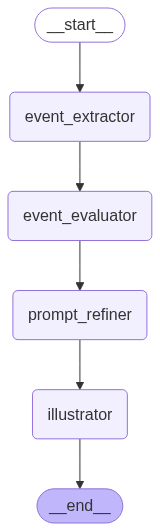

In [34]:
create_workflow().compile()

# Example


Extracted Events:

Event 1: In a room with a bed, three small monkeys are enthusiastically jumping together.
Event 2: In a room with a bed, one small monkey lies hurt after falling off, while two others continue to jump.
Event 3: In a room with a bed, two small monkeys continue to jump together after one left.
Event 4: In a room with a bed, a single small monkey jumps by himself.
Event 5: In a room with a bed, three small monkeys sleep peacefully after their energetic playtime.

Event Evaluation:

Semantic Similarity (SBERT): 0.7814701795578003
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Content Similarity (BERTScore): 0.8613848090171814
Coverage (ROUGE-L): 0.26490066225165565
Relevance (METEOR): 0.12413793103448277
Relevance Spread: 0.59808

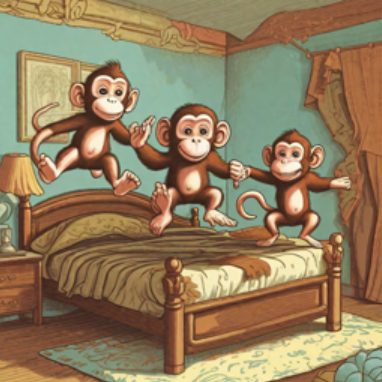

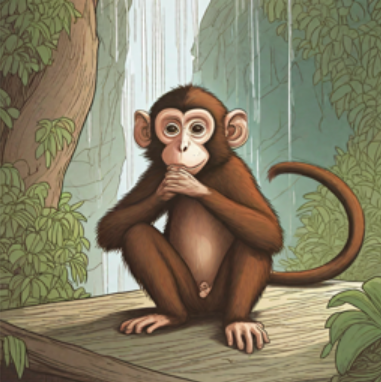

After anchor generation GPU memory usage:
Allocated VRAM: 8.06 GB
Reserved VRAM:  10.89 GB
[(1, 50)]
100%|██████████| 50/50 [14:53<00:00, 17.87s/it]
Extra prompt: An story illustration of A room with a bed features two small monkeys jumping together after one left.


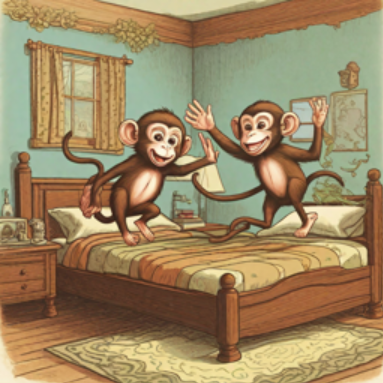

[(1, 50)]
100%|██████████| 50/50 [14:08<00:00, 16.97s/it]
Extra prompt: An story illustration of A small monkey jumps alone on a bed in a room.


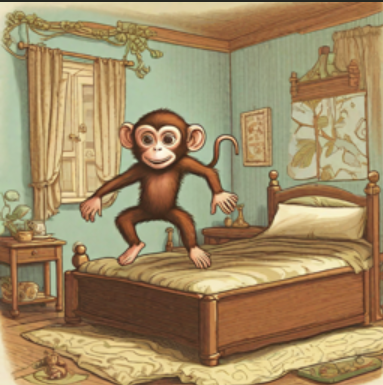

[(1, 50)]
100%|██████████| 50/50 [14:45<00:00, 17.70s/it]
Extra prompt: An story illustration of Three small monkeys sleep peacefully in a room with a bed after playtime.
      


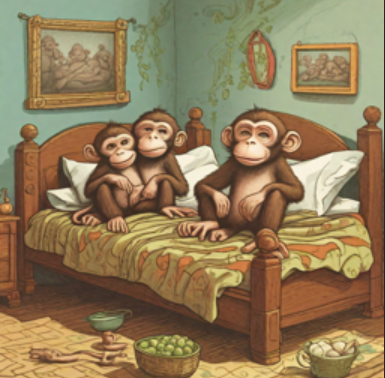

After extra generation GPU memory usage:
Allocated VRAM: 7.56 GB
Reserved VRAM:  8.96 GB
Maximum GPU memory used: 23.02 GB


In [ ]:
if __name__ == "__main__":
    # Run the workflow
    workflow = create_workflow().compile()


    initial_state = {
        "story": """ There once was three little monkeys jumping on the bed. They were having a great time, but then one of them fell off and bumped his head.
        The other monkeys didn't care, and continued jumping on the bed. So now, two monkeys were jumping on the bed. 
        After a while, only one monkey was left jumping on the bed.After jumping all day, the three monkeys were tired and slept on the bed.
"""
    }

    result = workflow.invoke(initial_state) 

### This is a simple example done to demonstrate the functionality of the project, The prompt refiner is set to only one iteration, so the results might not be the best. The aim is to show that the project works. 

# Visual Consistency Evaluation

In [36]:
import torch
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import numpy as np

# Load DINOv2 model and processor from Hugging Face
def load_dinov2_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    processor = AutoImageProcessor.from_pretrained("facebook/dino-vitb16")
    model = AutoModel.from_pretrained("facebook/dino-vitb16").to(device)
    model.eval()
    return model, processor, device

# Get single image embedding
def get_dinov2_embedding(image_path, model, processor, device):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        embedding = outputs.last_hidden_state[:, 0, :]  # CLS token

    return embedding.squeeze(0).cpu().numpy()

# Get embeddings for list of images
def get_dinov2_embeddings_for_images(image_paths):
    model, processor, device = load_dinov2_model()
    embeddings = {}
    for path in image_paths:
        embedding = get_dinov2_embedding(path, model, processor, device)
        embeddings[path] = embedding
    return embeddings

# Compute cosine similarity between all image pairs
def compare_dinov2_embeddings(embeddings):
    similarities = {}
    paths = list(embeddings.keys())

    for i in range(len(paths)):
        for j in range(i + 1, len(paths)):
            emb1 = embeddings[paths[i]]
            emb2 = embeddings[paths[j]]
            sim = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
            similarities[(paths[i], paths[j])] = sim
            print(f"Cosine similarity between {paths[i]} and {paths[j]}: {sim:.4f}")

    return similarities


In [37]:
# visualize DinoV2 embeddings
import matplotlib.pyplot as plt

def plot_dinov2_embeddings(embeddings):
    """Plot DINOv2 embeddings in 2D using PCA."""
    from sklearn.decomposition import PCA

    # Stack embeddings and apply PCA
    all_embeddings = np.vstack(list(embeddings.values()))
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(all_embeddings)

    # Plot the reduced embeddings
    plt.figure(figsize=(10, 8))
    for i, (path, emb) in enumerate(embeddings.items()):
        plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], label=os.path.basename(path))
        plt.annotate(os.path.basename(path), (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=9)

    plt.title("DINOv2 Embeddings Visualization")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()

# remove legend
def remove_legend(ax):
    """Remove legend from the axes."""
    ax.get_legend().remove()    

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Cosine similarity between GeneratedImages/1.png and GeneratedImages/2.png: 0.6024
Cosine similarity between GeneratedImages/1.png and GeneratedImages/3.png: 0.8904
Cosine similarity between GeneratedImages/1.png and GeneratedImages/4.png: 0.8719
Cosine similarity between GeneratedImages/1.png and GeneratedImages/5.png: 0.8086
Cosine similarity between GeneratedImages/2.png and GeneratedImages/3.png: 0.6169
Cosine similarity between GeneratedImages/2.png and GeneratedImages/4.png: 0.6499
Cosine similarity between GeneratedImages/2.png and GeneratedImages/5.png: 0.5504
Cosine similarity between GeneratedImages/3.png and GeneratedImages/4.png: 0.8870
Cosine similarity between GeneratedImages/3.png and GeneratedImages/5.png: 0.8208
Cosine similarity between GeneratedImages/4.png and GeneratedImages/5.png: 0.7981


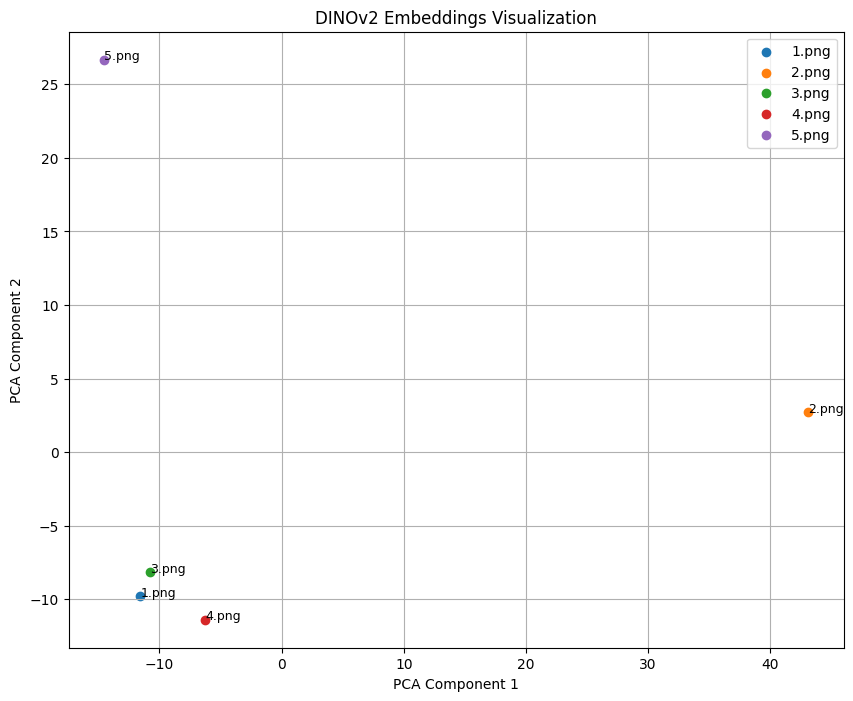

In [42]:
import os
image_paths = ["GeneratedImages/1.png", "GeneratedImages/2.png", "GeneratedImages/3.png", "GeneratedImages/4.png", "GeneratedImages/5.png"]
embeddings = get_dinov2_embeddings_for_images(image_paths)
similarities = compare_dinov2_embeddings(embeddings)
plot_dinov2_embeddings(embeddings)
